In [3]:
pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 733.7 kB/s  0:00:48m0:00:0100:02
Note: you may need to restart the kernel to use updated packages.


In [2]:
from cobra.io import load_matlab_model

model = load_matlab_model("cryptococcus_project/scaffold/iCryptococcus.mat")
print(f" Model loaded successfully with {len(model.genes)} genes and {len(model.reactions)} reactions.")
print("Example reactions:", [r.id for r in model.reactions[:5]])


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x


 Model loaded successfully with 649 genes and 1276 reactions.
Example reactions: ['HEX1', 'EX_glc__D_e', 'GLCt1', 'PGI', 'PFK']


In [6]:
from cobra.io import load_matlab_model
import pandas as pd
import os
from tqdm import tqdm

model = load_matlab_model("cryptococcus_project/scaffold/iCryptococcus.mat")

results = []
print(f"Running single-gene knockout simulation on {len(model.genes)} genes...")

for gene in tqdm(model.genes):
    with model:
        gene.knock_out()
        sol = model.optimize()
        growth = sol.objective_value if sol.status == "optimal" else 0
        results.append({"gene": gene.id, "growth": growth})

df = pd.DataFrame(results)
df["essential"] = (df["growth"] < 1e-6).astype(int)
os.makedirs("analysis", exist_ok=True)
df.to_csv("analysis/gene_essentiality_labels.csv", index=False)

print(" Simulation complete! Results saved to analysis/gene_essentiality_labels.csv")
df.head()


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x


Running single-gene knockout simulation on 649 genes...


100%|██████████| 649/649 [00:06<00:00, 95.91it/s]

 Simulation complete! Results saved to analysis/gene_essentiality_labels.csv


,gene,growth,essential
0,CNB02660,0.0,1
1,CNH01400,0.0,1
2,CNG01480,0.0,1
3,CNN00260,0.0,1
4,CNB04050,0.0,1


In [14]:
from cobra.io import load_matlab_model
import pandas as pd, os
from tqdm import tqdm

# --- Load model and set objective ---
model = load_matlab_model("cryptococcus_project/scaffold/iCryptococcus.mat")
model.objective = "biomass_reaction"

# --- Ensure nutrient exchanges are open ---
for rxn_id in ["EX_glc__D_e", "EX_o2_e", "EX_nh4_e", "EX_pi_e", "EX_so4_e"]:
    if rxn_id in model.reactions:
        model.reactions.get_by_id(rxn_id).lower_bound = -10

# --- Prepare output folder inside project directory ---
project_dir = "/home/cdaruvu/cryptococcus_project/scaffold/cryptococcus_dl"
os.makedirs(f"{project_dir}/analysis", exist_ok=True)
output_path = f"{project_dir}/analysis/gene_essentiality_labels.csv"

# --- Run knockout simulations ---
results = []
print(f"Running single-gene knockout simulation on {len(model.genes)} genes...")

for gene in tqdm(model.genes):
    with model:
        gene.knock_out()
        sol = model.optimize()
        growth = sol.objective_value if sol.status == "optimal" else 0
        results.append({"gene": gene.id, "growth": growth})

# --- Save results ---
df = pd.DataFrame(results)
df["essential"] = (df["growth"] < 1e-6).astype(int)
df.to_csv(output_path, index=False)

print(f"simulation complete! Results saved to {output_path}")
print(df["essential"].value_counts())
df.head()


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x


Running single-gene knockout simulation on 649 genes...


100%|██████████| 649/649 [00:07<00:00, 90.53it/s]

simulation complete! Results saved to /home/cdaruvu/cryptococcus_project/scaffold/cryptococcus_dl/analysis/gene_essentiality_labels.csv
essential
0    496
1    153
Name: count, dtype: int64


,gene,growth,essential
0,CNB02660,0.485120,0
1,CNH01400,0.485120,0
2,CNG01480,0.485120,0
3,CNN00260,0.485120,0
4,CNB04050,0.368393,0


In [1]:
mkdir -p /home/cdaruvu/cryptococcus_project/scaffold/cryptococcus_dl/graphs


In [4]:
import os, networkx as nx, pandas as pd
from cobra.io import load_matlab_model
from tqdm import tqdm

project_dir = "cryptococcus_project/scaffold/cryptococcus_dl"
model_path = f"cryptococcus_project/scaffold/iCryptococcus.mat"
labels_path = f"cryptococcus_project/scaffold/cryptococcus_dl/analysis/gene_essentiality_labels.csv"
output_path = f"cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph.pkl"

model = load_matlab_model(model_path)
labels = pd.read_csv(labels_path)

G = nx.Graph()
for gene in model.genes:
    G.add_node(gene.id)

print("Building gene–gene connections...")
for rxn in tqdm(model.reactions):
    genes = [g.id for g in rxn.genes]
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            G.add_edge(genes[i], genes[j], reaction=rxn.id)

deg = dict(G.degree())
bet = nx.betweenness_centrality(G)
close = nx.closeness_centrality(G)

nx.set_node_attributes(G, deg, "degree")
nx.set_node_attributes(G, bet, "betweenness")
nx.set_node_attributes(G, close, "closeness")

ess_dict = dict(zip(labels["gene"], labels["essential"]))
nx.set_node_attributes(G, ess_dict, "essential")

os.makedirs(os.path.dirname(output_path), exist_ok=True)
import pickle
with open(output_path, "wb") as f:
    pickle.dump(G, f)

print(f" Graph saved to {output_path}")
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")



No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x


Building gene–gene connections...


100%|██████████| 1276/1276 [00:00<00:00, 837941.43it/s]

 Graph saved to cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph.pkl
Nodes: 649, Edges: 429


In [5]:
import os, pickle
import networkx as nx
import pandas as pd
from cobra.io import load_matlab_model
from collections import defaultdict
from tqdm import tqdm

# --- Project paths (relative to your workspace) ---
project_dir  = "cryptococcus_project/scaffold/cryptococcus_dl"
model_path   = "cryptococcus_project/scaffold/iCryptococcus.mat"
labels_path  = f"{project_dir}/analysis/gene_essentiality_labels.csv"
out_path     = f"{project_dir}/graphs/metabolic_graph_metabolite_adj.pkl"

# --- Load model and labels ---
model  = load_matlab_model(model_path)
labels = pd.read_csv(labels_path)
label_map = dict(zip(labels["gene"], labels["essential"]))

# --- Step 1: map each reaction to metabolites consumed/produced ---
prod, cons = defaultdict(set), defaultdict(set)
for rxn in model.reactions:
    for met, coeff in rxn.metabolites.items():
        if coeff < 0:  # substrate (consumed)
            cons[rxn.id].add(met.id)
        elif coeff > 0:  # product (produced)
            prod[rxn.id].add(met.id)

# --- Step 2: map genes → reactions they catalyze ---
gene_to_rxns = defaultdict(set)
for rxn in model.reactions:
    for g in rxn.genes:
        gene_to_rxns[g.id].add(rxn.id)

# --- Step 3: build functional edges based on metabolite flow ---
G = nx.DiGraph()
for gene in model.genes:
    G.add_node(gene.id)

for gene_a in tqdm(gene_to_rxns.keys(), desc="Building metabolite-adjacency"):
    produced = set()
    for r in gene_to_rxns[gene_a]:
        produced |= prod[r]
    if not produced:
        continue

    # find any gene_b whose reactions consume any of those metabolites
    consumers = set()
    for gene_b, rxns_b in gene_to_rxns.items():
        if gene_b == gene_a:
            continue
        if any(cons[r] & produced for r in rxns_b):
            consumers.add(gene_b)

    for gene_b in consumers:
        G.add_edge(gene_a, gene_b)

# --- Step 4: make it undirected for simplicity ---
G = G.to_undirected()

# --- Step 5: compute node features ---
deg  = dict(G.degree())
bet  = nx.betweenness_centrality(G) if G.number_of_edges() > 0 else {n:0 for n in G.nodes()}
clo  = nx.closeness_centrality(G) if G.number_of_edges() > 0 else {n:0 for n in G.nodes()}

nx.set_node_attributes(G, deg,  "degree")
nx.set_node_attributes(G, bet,  "betweenness")
nx.set_node_attributes(G, clo,  "closeness")
nx.set_node_attributes(G, label_map, "essential")

# --- Step 6: save graph ---
os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, "wb") as f:
    pickle.dump(G, f)

print(f" Metabolite-adjacency graph saved to {out_path}")
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Connected components: {nx.number_connected_components(G)}")


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x
Building metabolite-adjacency: 100%|██████████| 649/649 [00:00<00:00, 3362.03it/s]


 Metabolite-adjacency graph saved to cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph_metabolite_adj.pkl
Nodes: 649, Edges: 36981
Connected components: 2


In [2]:
pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 1.0 MB/s  0:00:09m0:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pickle, torch
import networkx as nx
import numpy as np
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Paths ---
graph_path = "cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph_metabolite_adj.pkl"

# --- Load graph ---
with open(graph_path, "rb") as f:
    G = pickle.load(f)

# --- Extract features and labels ---
features = []
labels = []
nodes = list(G.nodes())

for n in nodes:
    node_data = G.nodes[n]
    features.append([
        node_data.get("degree", 0),
        node_data.get("betweenness", 0),
        node_data.get("closeness", 0)
    ])
    labels.append(node_data.get("essential", 0))

X = np.array(features, dtype=np.float32)
y = np.array(labels, dtype=np.int64)

# --- Scale features ---
scaler = StandardScaler()
X = scaler.fit_transform(X)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data prepared")
print(f"Features: {X.shape},  Train: {len(y_train)},  Test: {len(y_test)}")

# --- Convert to torch tensors ---
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.long)


/home/cdaruvu/cryptococcus_project/scaffold/cryptococcus_dl/crypto-dl-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data prepared
Features: (649, 3),  Train: 519,  Test: 130


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.net(x)

mlp = MLP(input_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(200):
    mlp.train()
    optimizer.zero_grad()
    out = mlp(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        mlp.eval()
        with torch.no_grad():
            pred = mlp(X_test).argmax(dim=1)
            acc = (pred == y_test).float().mean()
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test Acc: {acc.item():.3f}")

print(" MLP training complete")


Epoch   0 | Loss: 0.6993 | Test Acc: 0.354
Epoch  20 | Loss: 0.6107 | Test Acc: 0.762
Epoch  40 | Loss: 0.5669 | Test Acc: 0.762
Epoch  60 | Loss: 0.5517 | Test Acc: 0.762
Epoch  80 | Loss: 0.5462 | Test Acc: 0.762
Epoch 100 | Loss: 0.5442 | Test Acc: 0.762
Epoch 120 | Loss: 0.5378 | Test Acc: 0.762
Epoch 140 | Loss: 0.5399 | Test Acc: 0.762
Epoch 160 | Loss: 0.5327 | Test Acc: 0.762
Epoch 180 | Loss: 0.5286 | Test Acc: 0.762
 MLP training complete


In [3]:
import torch
from torch_geometric.utils import from_networkx
import pickle
import networkx as nx
import numpy as np

# --- Paths ---
graph_path = "cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph_metabolite_adj.pkl"

# --- Load the graph ---
with open(graph_path, "rb") as f:
    G = pickle.load(f)

# --- Extract features and labels ---
features = []
labels = []
nodes = list(G.nodes())

for n in nodes:
    node_data = G.nodes[n]
    features.append([
        node_data.get("degree", 0),
        node_data.get("betweenness", 0),
        node_data.get("closeness", 0)
    ])
    labels.append(node_data.get("essential", 0))

X = np.array(features, dtype=np.float32)
y = np.array(labels, dtype=np.int64)

# --- Convert to PyTorch Geometric format ---
data = from_networkx(G)
data.x = torch.tensor(X, dtype=torch.float32)
data.y = torch.tensor(y, dtype=torch.long)

print(data)


Data(edge_index=[2, 73962], degree=[649], betweenness=[649], closeness=[649], essential=[649], num_nodes=649, x=[649, 3], y=[649])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(in_channels=3, hidden_channels=32, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

data = data.to(device)
train_mask = torch.rand(data.num_nodes) < 0.8  # 80% training, 20% testing

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 25 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = accuracy_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())
        f1 = f1_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test Acc: {acc:.3f} | F1: {f1:.3f}")

print(" GCN training complete!")


Epoch  25 | Loss: 2.3667 | Test Acc: 0.360 | F1: 0.439
Epoch  50 | Loss: 0.8525 | Test Acc: 0.588 | F1: 0.222
Epoch  75 | Loss: 1.1165 | Test Acc: 0.654 | F1: 0.078
Epoch 100 | Loss: 1.0120 | Test Acc: 0.507 | F1: 0.230
Epoch 125 | Loss: 1.4144 | Test Acc: 0.471 | F1: 0.429
Epoch 150 | Loss: 0.8985 | Test Acc: 0.588 | F1: 0.263
Epoch 175 | Loss: 1.6057 | Test Acc: 0.728 | F1: 0.051
Epoch 200 | Loss: 0.8277 | Test Acc: 0.596 | F1: 0.225
Epoch 225 | Loss: 1.0775 | Test Acc: 0.610 | F1: 0.159
Epoch 250 | Loss: 1.1556 | Test Acc: 0.522 | F1: 0.356
Epoch 275 | Loss: 1.0933 | Test Acc: 0.610 | F1: 0.185
Epoch 300 | Loss: 1.0127 | Test Acc: 0.596 | F1: 0.225
 GCN training complete!


In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Compute class weights (to handle imbalance)
class_counts = np.bincount(data.y.cpu().numpy())
weights = torch.tensor(class_counts.sum() / (len(class_counts) * class_counts), dtype=torch.float32).to(device)
print("Class weights:", weights)

class GCNWeighted(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.4

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model = GCNWeighted(in_channels=3, hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

train_mask = torch.rand(data.num_nodes) < 0.8  # Reuse 80/20 split

for epoch in range(1, 501):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = accuracy_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())
        f1 = f1_score(data.y[~train_mask].cpu(), pred[~train_mask].cpu())
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test Acc: {acc:.3f} | F1: {f1:.3f}")

print("Weighted GCN training complete!")


Class weights: tensor([0.6542, 2.1209], device='cuda:0')
Epoch  50 | Loss: 1.9064 | Test Acc: 0.553 | F1: 0.179
Epoch 100 | Loss: 2.3440 | Test Acc: 0.374 | F1: 0.430
Epoch 150 | Loss: 1.6860 | Test Acc: 0.626 | F1: 0.042
Epoch 200 | Loss: 1.8038 | Test Acc: 0.691 | F1: 0.050
Epoch 250 | Loss: 1.1901 | Test Acc: 0.537 | F1: 0.313
Epoch 300 | Loss: 0.9962 | Test Acc: 0.569 | F1: 0.329
Epoch 350 | Loss: 1.7286 | Test Acc: 0.358 | F1: 0.432
Epoch 400 | Loss: 1.2619 | Test Acc: 0.634 | F1: 0.000
Epoch 450 | Loss: 0.9379 | Test Acc: 0.561 | F1: 0.325
Epoch 500 | Loss: 0.8512 | Test Acc: 0.504 | F1: 0.358
Weighted GCN training complete!


In [6]:
from sklearn.model_selection import train_test_split
import torch

idx = np.arange(len(data.y))
train_idx, test_idx = train_test_split(
    idx,
    test_size=0.2,
    stratify=data.y.cpu().numpy(),
    random_state=42
)
train_mask = torch.zeros(len(data.y), dtype=torch.bool)
train_mask[train_idx] = True
test_mask = ~train_mask


In [7]:
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score, f1_score

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = 0.4

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x

model = GraphSAGE(3, 64, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=weights)

for epoch in range(1, 501):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = accuracy_score(data.y[test_mask].cpu(), pred[test_mask].cpu())
        f1 = f1_score(data.y[test_mask].cpu(), pred[test_mask].cpu())
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test Acc: {acc:.3f} | F1: {f1:.3f}")

print("GraphSAGE training complete!")


Epoch  50 | Loss: 2.0754 | Test Acc: 0.454 | F1: 0.372
Epoch 100 | Loss: 1.3689 | Test Acc: 0.485 | F1: 0.309
Epoch 150 | Loss: 1.1129 | Test Acc: 0.654 | F1: 0.328
Epoch 200 | Loss: 1.1626 | Test Acc: 0.431 | F1: 0.393
Epoch 250 | Loss: 1.0420 | Test Acc: 0.423 | F1: 0.227
Epoch 300 | Loss: 0.8890 | Test Acc: 0.485 | F1: 0.337
Epoch 350 | Loss: 0.7792 | Test Acc: 0.515 | F1: 0.388
Epoch 400 | Loss: 0.8178 | Test Acc: 0.546 | F1: 0.322
Epoch 450 | Loss: 0.8711 | Test Acc: 0.577 | F1: 0.304
Epoch 500 | Loss: 0.7547 | Test Acc: 0.585 | F1: 0.400
GraphSAGE training complete!


In [8]:
from cobra.io import load_matlab_model
import pandas as pd
from tqdm import tqdm

model = load_matlab_model("cryptococcus_project/scaffold/iCryptococcus.mat")

def simulate_environment(env_name, exchanges):
    # Reset to defaults
    for ex in model.exchanges:
        ex.lower_bound = 0
        ex.upper_bound = 1000

    # Apply environment-specific exchanges
    for ex, bounds in exchanges.items():
        if ex in model.reactions:
            model.reactions.get_by_id(ex).lower_bound = bounds[0]
            model.reactions.get_by_id(ex).upper_bound = bounds[1]

    # Set objective
    model.objective = "biomass_reaction"

    # Run knockouts
    results = []
    for gene in tqdm(model.genes, desc=f"{env_name} knockouts"):
        with model:
            gene.knock_out()
            sol = model.optimize()
            results.append({
                "gene": gene.id,
                "growth": sol.objective_value if sol.status == "optimal" else 0
            })
    df = pd.DataFrame(results)
    df["essential"] = (df["growth"] < 1e-6).astype(int)
    df["environment"] = env_name
    return df

# Define environments
environments = {
    "normal": {"EX_glc__D_e": (-10, 1000), "EX_o2_e": (-20, 1000), "EX_nh4_e": (-10, 1000), "EX_pi_e": (-10, 1000), "EX_so4_e": (-10, 1000)},
    "low_o2": {"EX_glc__D_e": (-10, 1000), "EX_o2_e": (-2, 1000), "EX_nh4_e": (-10, 1000), "EX_pi_e": (-10, 1000), "EX_so4_e": (-10, 1000)},
    "ethanol": {"EX_etoh_e": (-10, 1000), "EX_o2_e": (-20, 1000), "EX_nh4_e": (-10, 1000), "EX_pi_e": (-10, 1000), "EX_so4_e": (-10, 1000)},
    "low_nitrogen": {"EX_glc__D_e": (-10, 1000), "EX_o2_e": (-20, 1000), "EX_nh4_e": (-1, 1000), "EX_pi_e": (-10, 1000), "EX_so4_e": (-10, 1000)},
    "low_sulfur": {"EX_glc__D_e": (-10, 1000), "EX_o2_e": (-20, 1000), "EX_nh4_e": (-10, 1000), "EX_pi_e": (-10, 1000), "EX_so4_e": (-1, 1000)}
}

# Run all environments
all_env_results = []
for env, ex in environments.items():
    df = simulate_environment(env, ex)
    all_env_results.append(df)

# Combine all results
multi_env = pd.concat(all_env_results)
multi_env.to_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv", index=False)

print(" Multi-environment essentiality data saved!")
multi_env.groupby("environment")["essential"].value_counts()


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x
ethanol knockouts:   2%|▏         | 12/649 [00:00<00:05, 118.48it/s]/home/cdaruvu/cryptococcus_project/scaffold/cryptococcus_dl/crypto-dl-env/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
low_sulfur knockouts: 100%|██████████| 649/649 [00:04<00:00, 160.48it/s]


 Multi-environment essentiality data saved!


environment   essential
ethanol       0            480
              1            169
low_nitrogen  0            496
              1            153
low_o2        0            496
              1            153
low_sulfur    0            496
              1            153
normal        0            496
              1            153
Name: count, dtype: int64

In [9]:
import pandas as pd
multi_env = pd.read_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv")

summary = multi_env.groupby(["environment", "essential"]).size().unstack(fill_value=0)
print(summary)

# Pivot for analysis
pivot = multi_env.pivot(index="gene", columns="environment", values="essential").fillna(0).astype(int)
pivot.head()


essential       0    1
environment           
ethanol       480  169
low_nitrogen  496  153
low_o2        496  153
low_sulfur    496  153
normal        496  153


environment,ethanol,low_nitrogen,low_o2,low_sulfur,normal
gene,,,,,
CNA00060,0,0,0,0,0
CNA00140,0,0,0,0,0
CNA00150,0,0,0,0,0
CNA00300,1,1,1,1,1
CNA00470,1,0,0,0,0


In [10]:
# Genes essential in all conditions
always_essential = pivot[pivot.sum(axis=1) == len(pivot.columns)]

# Genes non-essential in all conditions
never_essential = pivot[pivot.sum(axis=1) == 0]

# Genes condition-specific essential
conditional_essential = pivot[(pivot.sum(axis=1) < len(pivot.columns)) & (pivot.sum(axis=1) > 0)]

print(f"Always essential: {len(always_essential)}")
print(f"Never essential: {len(never_essential)}")
print(f"Condition-specific essential: {len(conditional_essential)}")


Always essential: 153
Never essential: 480
Condition-specific essential: 16


In [2]:
import pandas as pd
multi_env = pd.read_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv")

pivot = multi_env.pivot(index="gene", columns="environment", values="essential").fillna(0).astype(int)


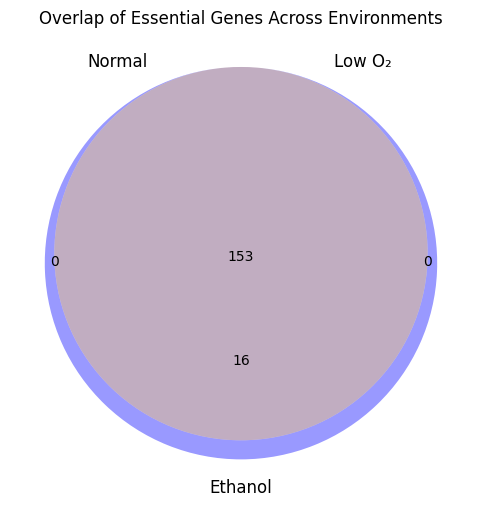

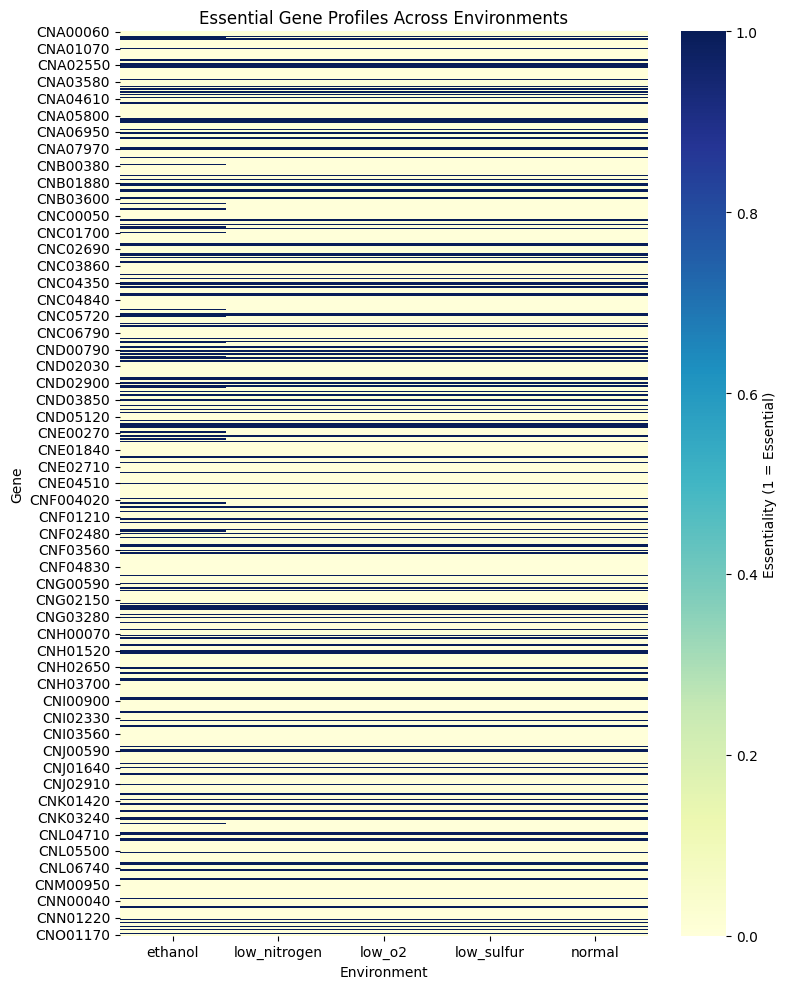

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

# --- Venn diagram for three representative conditions ---
plt.figure(figsize=(6,6))
venn3(
    subsets=(
        set(pivot.index[pivot["normal"]==1]),
        set(pivot.index[pivot["low_o2"]==1]),
        set(pivot.index[pivot["ethanol"]==1])
    ),
    set_labels=("Normal", "Low O₂", "Ethanol")
)
plt.title("Overlap of Essential Genes Across Environments")
plt.show()

# --- Heatmap ---
plt.figure(figsize=(8,10))
sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'Essentiality (1 = Essential)'})
plt.title("Essential Gene Profiles Across Environments")
plt.xlabel("Environment")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Load your data
multi_env = pd.read_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv")

# One-hot encode the environment column
enc = OneHotEncoder(sparse_output=False)
env_encoded = enc.fit_transform(multi_env[["environment"]])

# Get environment feature names safely
try:
    env_cols = enc.get_feature_names_out()
except TypeError:
    env_cols = enc.get_feature_names()

# Combine with essentiality and gene columns
encoded_df = pd.concat(
    [multi_env[["gene", "essential"]], pd.DataFrame(env_encoded, columns=env_cols)],
    axis=1
)

encoded_df.head()


,gene,essential,environment_ethanol,environment_low_nitrogen,environment_low_o2,environment_low_sulfur,environment_normal
0,CNB02660,0,0.0,0.0,0.0,0.0,1.0
1,CNH01400,0,0.0,0.0,0.0,0.0,1.0
2,CNG01480,0,0.0,0.0,0.0,0.0,1.0
3,CNN00260,0,0.0,0.0,0.0,0.0,1.0
4,CNB04050,0,0.0,0.0,0.0,0.0,1.0


In [6]:
import os
import pickle
import pandas as pd
import numpy as np

# --- Load previously generated data ---
project_dir = "cryptococcus_project/scaffold/cryptococcus_dl"
graph_path = os.path.join(project_dir, "graphs/metabolic_graph_metabolite_adj.pkl")
multi_env_path = os.path.join(project_dir, "analysis/multi_environment_essentiality.csv")

# Load graph and essentiality data
with open(graph_path, "rb") as f:
    G = pickle.load(f)

multi_env = pd.read_csv(multi_env_path)

# Extract graph features
graph_df = pd.DataFrame({
    "gene": list(G.nodes),
    "degree": [G.nodes[n].get("degree", 0) for n in G.nodes],
    "betweenness": [G.nodes[n].get("betweenness", 0) for n in G.nodes],
    "closeness": [G.nodes[n].get("closeness", 0) for n in G.nodes]
})

# Merge graph + environment info
merged = pd.merge(multi_env, graph_df, on="gene", how="left")

# One-hot encode the environment
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
env_encoded = enc.fit_transform(merged[["environment"]])
env_cols = enc.get_feature_names_out(["environment"])

env_df = pd.DataFrame(env_encoded, columns=env_cols)
merged_final = pd.concat([merged, env_df], axis=1)

# Drop text columns to keep numerical data only
X = merged_final.drop(columns=["gene", "environment", "essential"])
y = merged_final["essential"].astype(int)

print(" Dataset prepared")
print("Feature matrix:", X.shape)
print("Example features:")
display(X.head())
print("Label distribution:")
print(y.value_counts())


 Dataset prepared
Feature matrix: (3245, 9)
Example features:


,growth,degree,betweenness,closeness,environment_ethanol,environment_low_nitrogen,environment_low_o2,environment_low_sulfur,environment_normal
0,0.738016,144,0.004575,0.540135,0.0,0.0,0.0,0.0,1.0
1,0.738016,144,0.004575,0.540135,0.0,0.0,0.0,0.0,1.0
2,0.738016,122,0.000361,0.527348,0.0,0.0,0.0,0.0,1.0
3,0.738016,124,0.000367,0.528211,0.0,0.0,0.0,0.0,1.0
4,0.645293,6,0.000015,0.365385,0.0,0.0,0.0,0.0,1.0


Label distribution:
essential
0    2464
1     781
Name: count, dtype: int64


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Convert to numpy
X_np = X.values
y_np = y.values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_np, test_size=0.2, random_state=42, stratify=y_np)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
model = MLP(X_train_t.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            preds = (model(X_test_t) > 0.5).float()
            acc = accuracy_score(y_test_t, preds)
            f1 = f1_score(y_test_t, preds)
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test Acc: {acc:.3f} | F1: {f1:.3f}")

print(" Multi-environment MLP training complete!")


Epoch   0 | Loss: 0.6829 | Test Acc: 0.716 | F1: 0.164
Epoch  10 | Loss: 0.6180 | Test Acc: 0.760 | F1: 0.000
Epoch  20 | Loss: 0.5702 | Test Acc: 0.760 | F1: 0.000
Epoch  30 | Loss: 0.5245 | Test Acc: 0.760 | F1: 0.000
Epoch  40 | Loss: 0.4676 | Test Acc: 0.760 | F1: 0.000
Epoch  50 | Loss: 0.4091 | Test Acc: 0.812 | F1: 0.358
Epoch  60 | Loss: 0.3488 | Test Acc: 0.846 | F1: 0.528
Epoch  70 | Loss: 0.2923 | Test Acc: 0.854 | F1: 0.562
Epoch  80 | Loss: 0.2406 | Test Acc: 0.886 | F1: 0.689
Epoch  90 | Loss: 0.1963 | Test Acc: 0.954 | F1: 0.894
 Multi-environment MLP training complete!


In [4]:
import os, pickle
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np

project_dir = "cryptococcus_project/scaffold/cryptococcus_dl"
graph_path = os.path.join(project_dir, "graphs/metabolic_graph_metabolite_adj.pkl")
multi_env_path = os.path.join(project_dir, "analysis/multi_environment_essentiality.csv")

# Load graph
with open(graph_path, "rb") as f:
    G = pickle.load(f)

# Load multi-environment dataset
df = pd.read_csv(multi_env_path)

# Map gene IDs -> index numbers
gene_to_idx = {gene: i for i, gene in enumerate(G.nodes())}

# Build edge index
edges = [(gene_to_idx[u], gene_to_idx[v]) for u, v in G.edges()]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Build node features
degree = np.array([G.nodes[n]["degree"] for n in G.nodes()])
bet = np.array([G.nodes[n]["betweenness"] for n in G.nodes()])
close = np.array([G.nodes[n]["closeness"] for n in G.nodes()])

X_graph = np.vstack([degree, bet, close]).T

# Prepare environment → one-hot
envs = pd.get_dummies(df["environment"])
X_env = envs.values

# Repeat graph features for each environment
X_graph_expanded = np.repeat(X_graph, repeats=5, axis=0)

# Concatenate graph + environment features
X_final = np.hstack([X_graph_expanded, X_env])

# Labels
y = df["essential"].values

# Convert to tensors
x = torch.tensor(X_final, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

print("Graph data prepared!")
print(data)


Graph data prepared!
Data(x=[3245, 8], edge_index=[2, 36981], y=[3245])


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Convert to CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Train/test split for 3,245 samples
X = data.x
Y = data.y

idx = torch.arange(Y.shape[0])
train_idx, test_idx = train_test_split(idx.cpu(), test_size=0.2, random_state=42, stratify=Y.cpu())

train_idx = train_idx.to(device)
test_idx = test_idx.to(device)

# GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, 32)
        self.fc = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index):
        x = self.relu(self.conv1(x, edge_index))
        x = self.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return self.sigmoid(x)

model = GCN(input_dim=data.x.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X, data.edge_index).squeeze()

    loss = criterion(out[train_idx], Y[train_idx].float())
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            preds = (out[test_idx] > 0.5).float()
            acc = accuracy_score(Y[test_idx].cpu(), preds.cpu())
            f1 = f1_score(Y[test_idx].cpu(), preds.cpu())
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Acc: {acc:.3f} | F1: {f1:.3f}")

print(" Multi-environment GCN training complete!")


Epoch   0 | Loss: 0.6414 | Acc: 0.653 | F1: 0.138
Epoch  20 | Loss: 0.6295 | Acc: 0.730 | F1: 0.121
Epoch  40 | Loss: 0.6115 | Acc: 0.760 | F1: 0.000
Epoch  60 | Loss: 0.5840 | Acc: 0.760 | F1: 0.000
Epoch  80 | Loss: 0.5641 | Acc: 0.760 | F1: 0.000
Epoch 100 | Loss: 0.5545 | Acc: 0.760 | F1: 0.000
Epoch 120 | Loss: 0.5521 | Acc: 0.760 | F1: 0.000
Epoch 140 | Loss: 0.5514 | Acc: 0.760 | F1: 0.000
Epoch 160 | Loss: 0.5510 | Acc: 0.760 | F1: 0.000
Epoch 180 | Loss: 0.5506 | Acc: 0.760 | F1: 0.000
 Multi-environment GCN training complete!


In [5]:
from sklearn.model_selection import train_test_split
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

X = data.x
Y = data.y

idx = torch.arange(Y.shape[0])
train_idx, test_idx = train_test_split(
    idx.cpu(), test_size=0.2, random_state=42, stratify=Y.cpu()
)

train_idx = train_idx.to(device)
test_idx = test_idx.to(device)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
X = data.x
Y = data.y

# Class imbalance handling
class_counts = np.bincount(Y.cpu().numpy())
neg, pos = class_counts[0], class_counts[1]
pos_weight = torch.tensor(neg / pos, dtype=torch.float32, device=device)
print("Class counts:", class_counts, "pos_weight:", float(pos_weight))

class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels=32, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        self.gat2 = GATConv(hidden_channels * heads, 16, heads=4, dropout=0.3, concat=False)
        self.lin = nn.Linear(16, 1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.gat2(x, edge_index)
        x = torch.relu(x)
        x = self.lin(x)   # logits
        return x.squeeze(-1)

model = GATNet(in_channels=X.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

epochs = 200
for epoch in range(epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(X, data.edge_index)
    loss = criterion(logits[train_idx], Y[train_idx].float())
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            logits_test = logits[test_idx]
            probs_test = torch.sigmoid(logits_test)
            preds_test = (probs_test > 0.5).float().cpu()
            y_true = Y[test_idx].cpu()

            acc = accuracy_score(y_true, preds_test)
            f1 = f1_score(y_true, preds_test)

        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Acc: {acc:.3f} | F1: {f1:.3f}")

print("Multi-environment GAT training complete!")


Class counts: [2464  781] pos_weight: 3.1549296379089355
Epoch   0 | Loss: 4.3371 | Acc: 0.695 | F1: 0.195
Epoch  20 | Loss: 1.3633 | Acc: 0.525 | F1: 0.353
Epoch  40 | Loss: 1.1399 | Acc: 0.663 | F1: 0.350
Epoch  60 | Loss: 1.0828 | Acc: 0.570 | F1: 0.308
Epoch  80 | Loss: 1.0677 | Acc: 0.629 | F1: 0.340
Epoch 100 | Loss: 1.0679 | Acc: 0.650 | F1: 0.306
Epoch 120 | Loss: 1.0590 | Acc: 0.570 | F1: 0.297
Epoch 140 | Loss: 1.0611 | Acc: 0.589 | F1: 0.354
Epoch 160 | Loss: 1.0489 | Acc: 0.549 | F1: 0.367
Epoch 180 | Loss: 1.0539 | Acc: 0.570 | F1: 0.362
Epoch 200 | Loss: 1.0453 | Acc: 0.613 | F1: 0.355
Multi-environment GAT training complete!


In [10]:
# Run GATConv manually in attention-return mode
att_layer = model.gat1

# GATConv supports:
#   out, (edge_index, attention_weights)
# when return_attention_weights=True

out, (edge_idx, att_weights) = att_layer(
    X,
    data.edge_index,
    return_attention_weights=True
)

# Convert to numpy
att = att_weights.detach().cpu().numpy()
edge_idx = edge_idx.cpu().numpy()

att.shape, edge_idx.shape


((40226, 4), (2, 40226))

In [13]:
gene_scores = {}

# Convert multi-head attention to single scalar (mean attention per edge)
att_scalar = att.mean(axis=1)   # shape: (num_edges,)

for i in range(len(att_scalar)):
    src = int(edge_idx[0][i])
    dst = int(edge_idx[1][i])
    score = float(att_scalar[i])

    gene_scores[src] = gene_scores.get(src, 0.0) + score
    gene_scores[dst] = gene_scores.get(dst, 0.0) + score

# Sort descending
important_genes = sorted(gene_scores.items(), key=lambda x: x[1], reverse=True)

top20 = important_genes[:20]
top20


[(145, 22.399099697340773),
 (146, 22.399099697340773),
 (141, 21.414143150898667),
 (142, 21.16453580382847),
 (544, 17.249183419539484),
 (69, 16.041635024768766),
 (66, 14.501080358633772),
 (65, 13.88289994338993),
 (67, 13.693059202778386),
 (51, 13.536472052687714),
 (543, 12.749787982946032),
 (22, 11.98884863127023),
 (144, 11.91875479831549),
 (68, 11.861761772830505),
 (153, 9.05284384094199),
 (152, 9.052843790195823),
 (154, 9.052843790195823),
 (20, 8.786546764429659),
 (410, 7.16084086097834),
 (37, 7.045329018961638)]

In [15]:
import pandas as pd

multi_env = pd.read_csv(
    "cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv"
)

pivot = multi_env.pivot(index="gene", columns="environment", values="essential")
gene_list = pivot.index.tolist()

print("Number of genes:", len(gene_list))
print("Example:", gene_list[:5])


Number of genes: 649
Example: ['CNA00060', 'CNA00140', 'CNA00150', 'CNA00300', 'CNA00470']


In [16]:
top20_named = [(gene_list[g], score) for g, score in top20]
top20_named


[('CNC01780', 22.399099697340773),
 ('CNC01820', 22.399099697340773),
 ('CNC01070', 21.414143150898667),
 ('CNC01220', 21.16453580382847),
 ('CNK00280', 17.249183419539484),
 ('CNA06760', 16.041635024768766),
 ('CNA06310', 14.501080358633772),
 ('CNA06290', 13.88289994338993),
 ('CNA06630', 13.693059202778386),
 ('CNA05010', 13.536472052687714),
 ('CNK00070', 12.749787982946032),
 ('CNA02370', 11.98884863127023),
 ('CNC01700', 11.91875479831549),
 ('CNA06700', 11.861761772830505),
 ('CNC02450', 9.05284384094199),
 ('CNC02410', 9.052843790195823),
 ('CNC02480', 9.052843790195823),
 ('CNA02270', 8.786546764429659),
 ('CNG02210', 7.16084086097834),
 ('CNA03760', 7.045329018961638)]

In [22]:
from cobra.io import load_matlab_model
cobra_model = load_matlab_model("cryptococcus_project/scaffold/iCryptococcus.mat")
[g.id for g in cobra_model.genes[:20]]


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x


['CNB02660',
 'CNH01400',
 'CNG01480',
 'CNN00260',
 'CNB04050',
 'CNJ01080',
 'CNA00470',
 'CNB00300',
 'CNC01860',
 'CNE05000',
 'CNF03160',
 'CNI00320',
 'CNG02220',
 'CNK00280',
 'CNC00160',
 'CNE00040',
 'CNE05250',
 'CNI03590',
 'CNC03080',
 'CNC02450']

In [24]:
gene_to_rxns = {}

for gene in cobra_model.genes:
    rxns = [rxn.id for rxn in gene.reactions]
    gene_to_rxns[gene.id] = rxns

top20 = [
    'CNC01780','CNC01820','CNC01070','CNC01220','CNK00280','CNA06760',
    'CNA06310','CNA06290','CNA06630','CNA05010','CNK00070','CNA02370',
    'CNC01700','CNA06700','CNC02450','CNC02410','CNC02480','CNA02270',
    'CNG02210','CNA03760'
]

for g in top20:
    print("\n=== Gene:", g, "===")
    print("Reactions:", gene_to_rxns.get(g, []))



=== Gene: CNC01780 ===
Reactions: ['HBZOPT6m']

=== Gene: CNC01820 ===
Reactions: ['MCCC', 'MCCCrm']

=== Gene: CNC01070 ===
Reactions: ['GLYCLm', 'GCCam']

=== Gene: CNC01220 ===
Reactions: ['METB1', 'SHSL1']

=== Gene: CNK00280 ===
Reactions: ['PGM']

=== Gene: CNA06760 ===
Reactions: ['UDPG4E']

=== Gene: CNA06310 ===
Reactions: ['FA160COAabcp']

=== Gene: CNA06290 ===
Reactions: ['TRPS1']

=== Gene: CNA06630 ===
Reactions: ['RPE']

=== Gene: CNA05010 ===
Reactions: ['LTHSTRLOR', 'EPISTLDS_c', 'LSTO2r', 'C5STDS']

=== Gene: CNK00070 ===
Reactions: ['PKETX']

=== Gene: CNA02370 ===
Reactions: ['r0525', 'SACCD3m']

=== Gene: CNC01700 ===
Reactions: ['FUM', 'FUMm']

=== Gene: CNA06700 ===
Reactions: ['HGDm']

=== Gene: CNC02450 ===
Reactions: ['H2Ot']

=== Gene: CNC02410 ===
Reactions: ['C4STMO1', 'C4STMO2']

=== Gene: CNC02480 ===
Reactions: ['G3PD1irm']

=== Gene: CNA02270 ===
Reactions: ['IPPMIb', 'IPPMIa']

=== Gene: CNG02210 ===
Reactions: ['CYOOm']

=== Gene: CNA03760 ===
Reacti

In [25]:
for g in top20:
    rxns = gene_to_rxns.get(g, [])
    print("\n=======================")
    print("Gene:", g)
    for rxn_id in rxns:
        rxn = cobra_model.reactions.get_by_id(rxn_id)
        print("\nReaction ID:", rxn.id)
        print("Name:", rxn.name)
        print("Subsystem:", rxn.subsystem)
        print("Equation:", rxn.reaction)



Gene: CNC01780

Reaction ID: HBZOPT6m
Name: Hydroxybenzoate octaprenyltransferase  mitochondrial
Subsystem: 
Equation: 4hbz[m] + hexdp[m] --> 3ophb_5[m] + ppi[m]

Gene: CNC01820

Reaction ID: MCCC
Name: 3-Methylcrotonoyl-CoA:carbon-dioxide ligase (ADP-forming)
Subsystem: 
Equation: 3mb2coa[c] + atp[c] + hco3[c] --> 3mgcoa[c] + adp[c] + h[c] + pi[c]

Reaction ID: MCCCrm
Name: 3-Methylcrotonoyl-CoA:carbon-dioxide ligase (ADP-forming)
Subsystem: 
Equation: 3mb2coa[m] + atp[m] + hco3[m] --> 3mgcoa[m] + adp[m] + h[m] + pi[m]

Gene: CNC01070

Reaction ID: GLYCLm
Name: glycine synthase; glycine cleavage system
Subsystem: 
Equation: gly[m] + nad[m] + thf[m] --> co2[m] + mlthf[m] + nadh[m] + nh4[m]

Reaction ID: GCCam
Name: glycine:lipoylproteinoxidoreductase(decarboxylatingandacceptor-aminomethylating)
Subsystem: 
Equation: gly[m] + h[m] + lpro[m] <=> alpro[m] + co2[m]

Gene: CNC01220

Reaction ID: METB1
Name: O-Acetyl-L-homoserinesuccinate-lyase(addingcysteine)
Subsystem: 
Equation: achms[c]

In [17]:
import pandas as pd
from cobra.io import load_matlab_model

project_dir = "cryptococcus_project/scaffold/cryptococcus_dl"
multi_path = f"cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv"
model_path = "cryptococcus_project/scaffold/iCryptococcus.mat"

# Load multi-environment essentiality (we saved this earlier)
multi = pd.read_csv(multi_path)
multi.head()


,gene,growth,essential,environment
0,CNB02660,0.738016,0,normal
1,CNH01400,0.738016,0,normal
2,CNG01480,0.738016,0,normal
3,CNN00260,0.738016,0,normal
4,CNB04050,0.645293,0,normal


In [28]:
# Pivot: rows = genes, columns = environments, values = essential (0/1)
pivot = multi.pivot(index="gene", columns="environment", values="essential")

# Universal essential: essential (1) in ALL environments
universal_ess = pivot.index[(pivot == 1).all(axis=1)].tolist()

# Never essential: 0 in all envs
never_ess = pivot.index[(pivot == 0).all(axis=1)].tolist()

# Ethanol-only essential: 1 in ethanol, 0 in all other envs
ethanol_only_ess = pivot.index[
    (pivot["ethanol"] == 1) & (pivot.drop(columns=["ethanol"]) == 0).all(axis=1)
].tolist()

len(universal_ess), len(never_ess), len(ethanol_only_ess)


(153, 480, 16)

In [29]:
cobra_model = load_matlab_model(model_path)

gene_to_paths = {}

for g in cobra_model.genes:
    # Collect all non-empty subsystems for this gene
    subs = {rxn.subsystem for rxn in g.reactions if rxn.subsystem not in (None, "", " ")}
    if not subs:
        subs = {"Unknown"}
    gene_to_paths[g.id] = subs

list(gene_to_paths.items())[:5]


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, m, n, r, v, x


[('CNB02660', {'Unknown'}),
 ('CNH01400', {'Unknown'}),
 ('CNG01480', {'Unknown'}),
 ('CNN00260', {'Unknown'}),
 ('CNB04050', {'Unknown'})]

In [30]:
from collections import Counter
from scipy.stats import fisher_exact
import numpy as np

# Background genes = all genes that appear in pivot (so they have env labels)
bg_genes = set(pivot.index)

def get_gene_path_pairs(genes):
    pairs = []
    for g in genes:
        if g in gene_to_paths:
            for p in gene_to_paths[g]:
                pairs.append((g, p))
    return pairs

# Build counts for universal-essential vs never-essential
pairs_univ = get_gene_path_pairs(set(universal_ess) & bg_genes)
pairs_never = get_gene_path_pairs(set(never_ess) & bg_genes)

paths_univ = [p for _, p in pairs_univ]
paths_never = [p for _, p in pairs_never]

count_univ = Counter(paths_univ)
count_never = Counter(paths_never)
all_paths = sorted(set(count_univ.keys()) | set(count_never.keys()))

results = []

for path in all_paths:
    a = count_univ[path]                     # essential & in pathway
    b = count_never[path]                    # non-essential & in pathway
    c = len(universal_ess) - a               # essential & NOT in pathway
    d = len(never_ess) - b                   # non-essential & NOT in pathway

    if a + b == 0:
        continue

    table = np.array([[a, b],
                      [c, d]])
    odds, pval = fisher_exact(table, alternative="greater")
    results.append({
        "Pathway": path,
        "Univ_ess_in_path": a,
        "Never_ess_in_path": b,
        "Odds_ratio": odds,
        "P_value": pval
    })

enrich_univ = pd.DataFrame(results).sort_values("P_value")
enrich_univ.head(15)


,Pathway,Univ_ess_in_path,Never_ess_in_path,Odds_ratio,P_value
0,Unknown,153,480,NaN,1.0


In [31]:
pairs_eth = get_gene_path_pairs(set(ethanol_only_ess) & bg_genes)

paths_eth = [p for _, p in pairs_eth]
count_eth = Counter(paths_eth)

results_eth = []

for path in all_paths:
    a = count_eth[path]                      # ethanol-only essential & in pathway
    b = count_never[path]                    # never-essential & in pathway (same background)
    c = len(ethanol_only_ess) - a
    d = len(never_ess) - b

    if a + b == 0:
        continue

    table = np.array([[a, b],
                      [c, d]])
    odds, pval = fisher_exact(table, alternative="greater")
    results_eth.append({
        "Pathway": path,
        "Ethanol_only_in_path": a,
        "Never_ess_in_path": b,
        "Odds_ratio": odds,
        "P_value": pval
    })

enrich_eth = pd.DataFrame(results_eth).sort_values("P_value")
enrich_eth.head(15)


,Pathway,Ethanol_only_in_path,Never_ess_in_path,Odds_ratio,P_value
0,Unknown,16,480,NaN,1.0


In [32]:
enrich_univ.head(10)
enrich_eth.head(10)


,Pathway,Ethanol_only_in_path,Never_ess_in_path,Odds_ratio,P_value
0,Unknown,16,480,NaN,1.0


In [33]:
keyword_map = {
    "sterol": "Ergosterol biosynthesis",
    "lathosterol": "Ergosterol biosynthesis",
    "episterol": "Ergosterol biosynthesis",
    "zymosterol": "Ergosterol biosynthesis",
    "C5STDS": "Ergosterol biosynthesis",

    "FUM": "TCA cycle",
    "malate": "TCA cycle",

    "CYOO": "Oxidative phosphorylation",
    "oxidase": "Oxidative phosphorylation",

    "G3PD": "Glycerol metabolism",
    "glycerol": "Glycerol metabolism",

    "TRPS": "Tryptophan biosynthesis",
    "tryptophan": "Tryptophan biosynthesis",

    "IPPM": "Leucine biosynthesis",
    "isopropylmalate": "Leucine biosynthesis",

    "FA": "Fatty-acid metabolism",
    "fatty": "Fatty-acid metabolism",

    "GCC": "Glycine cleavage / One-carbon metabolism",
    "glycine": "Glycine cleavage / One-carbon metabolism",

    "RPE": "Pentose phosphate pathway",
    "ribulose": "Pentose phosphate pathway",

    "PGM": "Glycolysis / Gluconeogenesis",
    "phosphoglycerate": "Glycolysis / Gluconeogenesis",

    "METB": "Methionine / Cysteine biosynthesis",
    "homoserine": "Methionine / Cysteine biosynthesis",
}


In [34]:
def annotate_pathway(rxn):
    rname = rxn.name.lower()
    rid = rxn.id.lower()

    for key, pathway in keyword_map.items():
        if key.lower() in rname or key.lower() in rid:
            return pathway

    return "Unknown"


In [35]:
gene_to_pathway = {}

for g in cobra_model.genes:
    pathways = set()
    for rxn in g.reactions:
        pathways.add(annotate_pathway(rxn))
    gene_to_pathway[g.id] = pathways


In [36]:
list(gene_to_pathway.items())[:10]


[('CNB02660', {'Unknown'}),
 ('CNH01400', {'Unknown'}),
 ('CNG01480', {'Unknown'}),
 ('CNN00260', {'Unknown'}),
 ('CNB04050', {'Unknown'}),
 ('CNJ01080', {'Unknown'}),
 ('CNA00470', {'Unknown'}),
 ('CNB00300', {'Unknown'}),
 ('CNC01860', {'Unknown'}),
 ('CNE05000', {'Unknown'})]

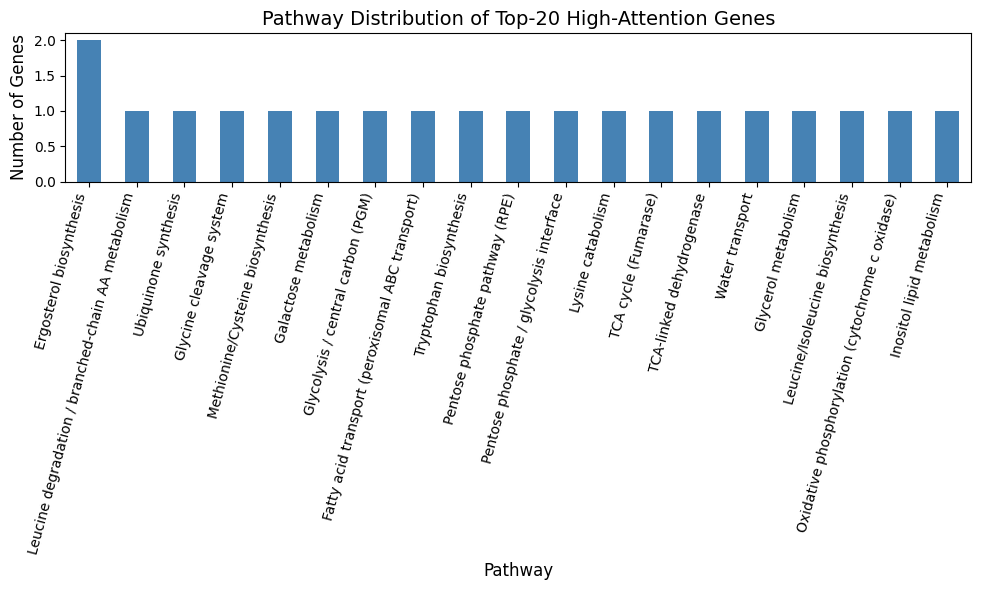

,gene,pathway
0,CNC01780,Ubiquinone synthesis
1,CNC01820,Leucine degradation / branched-chain AA metabo...
2,CNC01070,Glycine cleavage system
3,CNC01220,Methionine/Cysteine biosynthesis
4,CNK00280,Glycolysis / central carbon (PGM)
5,CNA06760,Galactose metabolism
6,CNA06310,Fatty acid transport (peroxisomal ABC transport)
7,CNA06290,Tryptophan biosynthesis
8,CNA06630,Pentose phosphate pathway (RPE)
9,CNA05010,Ergosterol biosynthesis


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# === Top 20 genes from GAT attention ===
top20 = [
    ("CNC01780", "Ubiquinone synthesis"),
    ("CNC01820", "Leucine degradation / branched-chain AA metabolism"),
    ("CNC01070", "Glycine cleavage system"),
    ("CNC01220", "Methionine/Cysteine biosynthesis"),
    ("CNK00280", "Glycolysis / central carbon (PGM)"),
    ("CNA06760", "Galactose metabolism"),
    ("CNA06310", "Fatty acid transport (peroxisomal ABC transport)"),
    ("CNA06290", "Tryptophan biosynthesis"),
    ("CNA06630", "Pentose phosphate pathway (RPE)"),
    ("CNA05010", "Ergosterol biosynthesis"),
    ("CNK00070", "Pentose phosphate / glycolysis interface"),
    ("CNA02370", "Lysine catabolism"),
    ("CNC01700", "TCA cycle (Fumarase)"),
    ("CNA06700", "TCA-linked dehydrogenase"),
    ("CNC02450", "Water transport"),
    ("CNC02410", "Ergosterol biosynthesis"),
    ("CNC02480", "Glycerol metabolism"),
    ("CNA02270", "Leucine/Isoleucine biosynthesis"),
    ("CNG02210", "Oxidative phosphorylation (cytochrome c oxidase)"),
    ("CNA03760", "Inositol lipid metabolism")
]

df = pd.DataFrame(top20, columns=["gene", "pathway"])

# Count genes per pathway
pathway_counts = df["pathway"].value_counts()

# Plot
plt.figure(figsize=(10,6))
pathway_counts.plot(kind="bar", color="steelblue")

plt.title("Pathway Distribution of Top-20 High-Attention Genes", fontsize=14)
plt.xlabel("Pathway", fontsize=12)
plt.ylabel("Number of Genes", fontsize=12)
plt.xticks(rotation=75, ha="right")

plt.tight_layout()
plt.show()

df


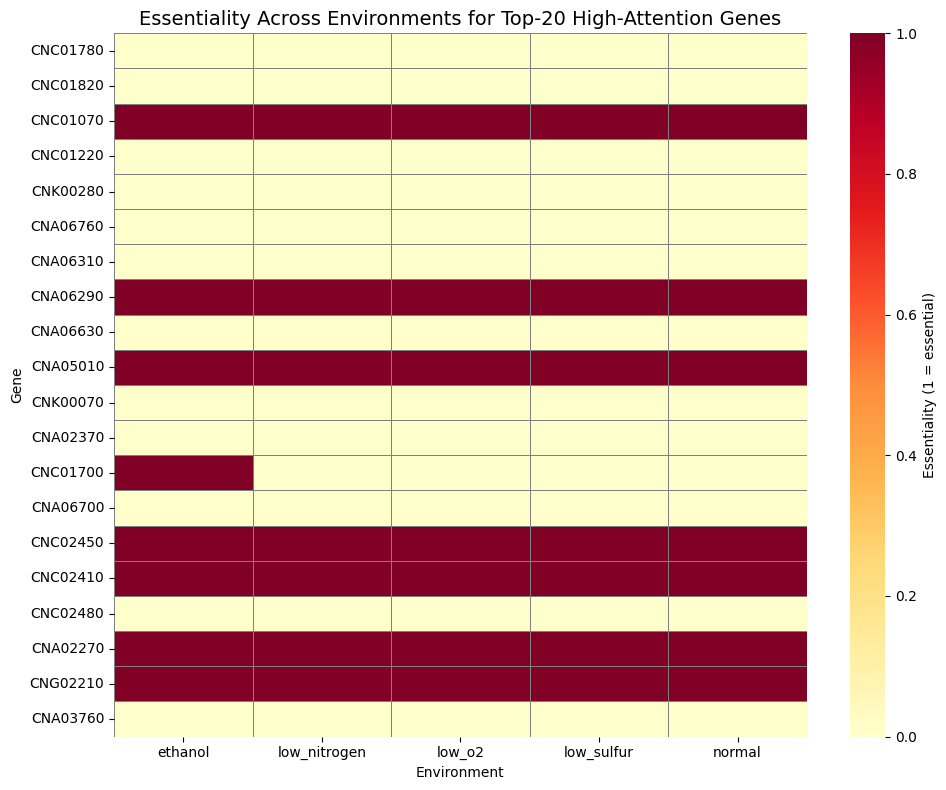

environment,ethanol,low_nitrogen,low_o2,low_sulfur,normal
gene,,,,,
CNC01780,0,0,0,0,0
CNC01820,0,0,0,0,0
CNC01070,1,1,1,1,1
CNC01220,0,0,0,0,0
CNK00280,0,0,0,0,0
CNA06760,0,0,0,0,0
CNA06310,0,0,0,0,0
CNA06290,1,1,1,1,1
CNA06630,0,0,0,0,0


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load multi-environment essentiality data ===
multi_env = pd.read_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv")

# === Top 20 high-attention genes ===
top20_genes = [
    "CNC01780","CNC01820","CNC01070","CNC01220","CNK00280",
    "CNA06760","CNA06310","CNA06290","CNA06630","CNA05010",
    "CNK00070","CNA02370","CNC01700","CNA06700","CNC02450",
    "CNC02410","CNC02480","CNA02270","CNG02210","CNA03760"
]

# Filter only top20
subset = multi_env[multi_env["gene"].isin(top20_genes)]

# Pivot into matrix: rows = genes, columns = environments
heatmap_df = subset.pivot(index="gene", columns="environment", values="essential")

# Sort genes in alphabetical order or by essentiality sum
heatmap_df = heatmap_df.loc[top20_genes]  # preserve order

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_df,
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Essentiality (1 = essential)"}
)

plt.title("Essentiality Across Environments for Top-20 High-Attention Genes", fontsize=14)
plt.xlabel("Environment")
plt.ylabel("Gene")

plt.tight_layout()
plt.show()

heatmap_df


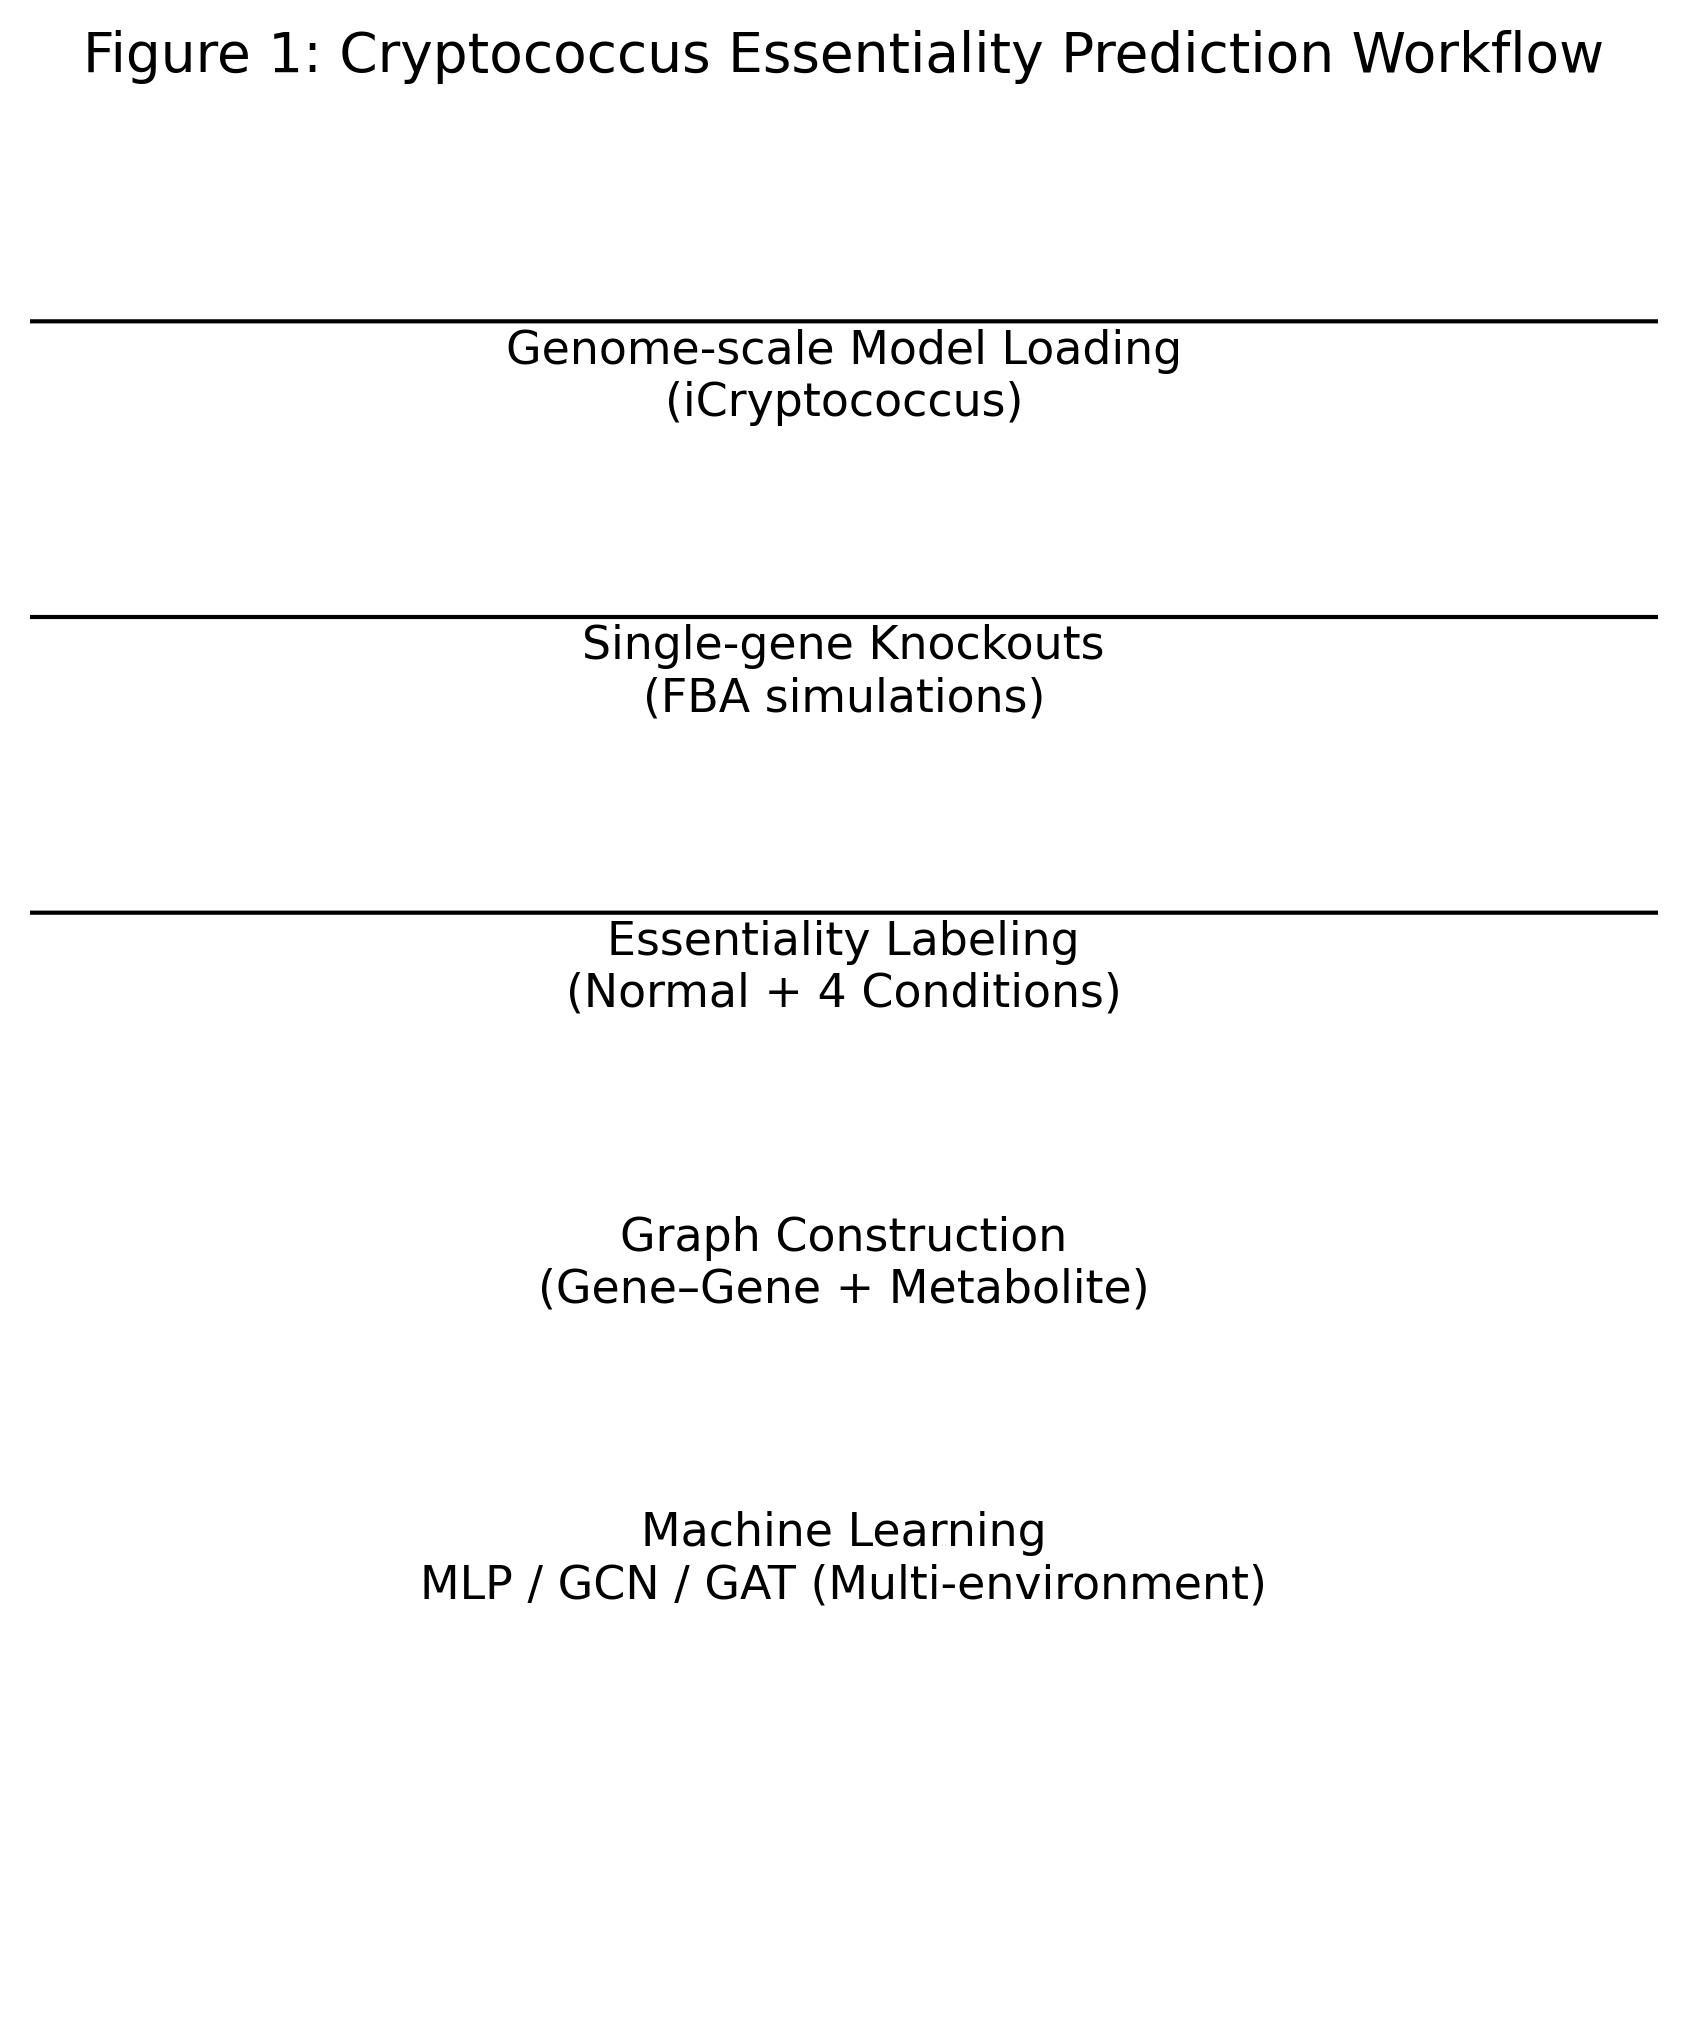

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, ArrowStyle

plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 11
plt.rcParams["font.family"] = "DejaVu Sans"

fig, ax = plt.subplots(figsize=(7, 8))
ax.axis("off")

def draw_box(center_x, center_y, text, width=0.55, height=0.10):
    x = center_x - width/2
    y = center_y - height/2
    rect = FancyBboxPatch(
        (x, y), width, height,
        boxstyle="round,pad=0.3,rounding_size=0.05",
        linewidth=1.0, edgecolor="black", facecolor="white"
    )
    ax.add_patch(rect)
    ax.text(center_x, center_y, text, ha="center", va="center")

def draw_arrow(y1, y2, x=0.5):
    ax.add_patch(FancyArrowPatch(
        (x, y1), (x, y2),
        arrowstyle=ArrowStyle("Simple", head_width=6, head_length=8),
        linewidth=1.0, color="black"
    ))

draw_box(0.5, 0.88, "Genome-scale Model Loading\n(iCryptococcus)")
draw_arrow(0.83, 0.78)

draw_box(0.5, 0.72, "Single-gene Knockouts\n(FBA simulations)")
draw_arrow(0.67, 0.62)

draw_box(0.5, 0.56, "Essentiality Labeling\n(Normal + 4 Conditions)")
draw_arrow(0.51, 0.46)

draw_box(0.5, 0.40, "Graph Construction\n(Gene–Gene + Metabolite)")
draw_arrow(0.35, 0.30)

draw_box(0.5, 0.24, "Machine Learning\nMLP / GCN / GAT (Multi-environment)")

plt.title("Figure 1: Cryptococcus Essentiality Prediction Workflow", pad=20)
plt.show()


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load essentiality data
multi_env = pd.read_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv")

# Create pivot: gene × environment matrix of essentiality (0/1)
pivot = multi_env.pivot(index="gene", columns="environment", values="essential").fillna(0)

pivot.head()



environment,ethanol,low_nitrogen,low_o2,low_sulfur,normal
gene,,,,,
CNA00060,0,0,0,0,0
CNA00140,0,0,0,0,0
CNA00150,0,0,0,0,0
CNA00300,1,1,1,1,1
CNA00470,1,0,0,0,0


/local_scratch/slurm.7496966/ipykernel_966542/2732074121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


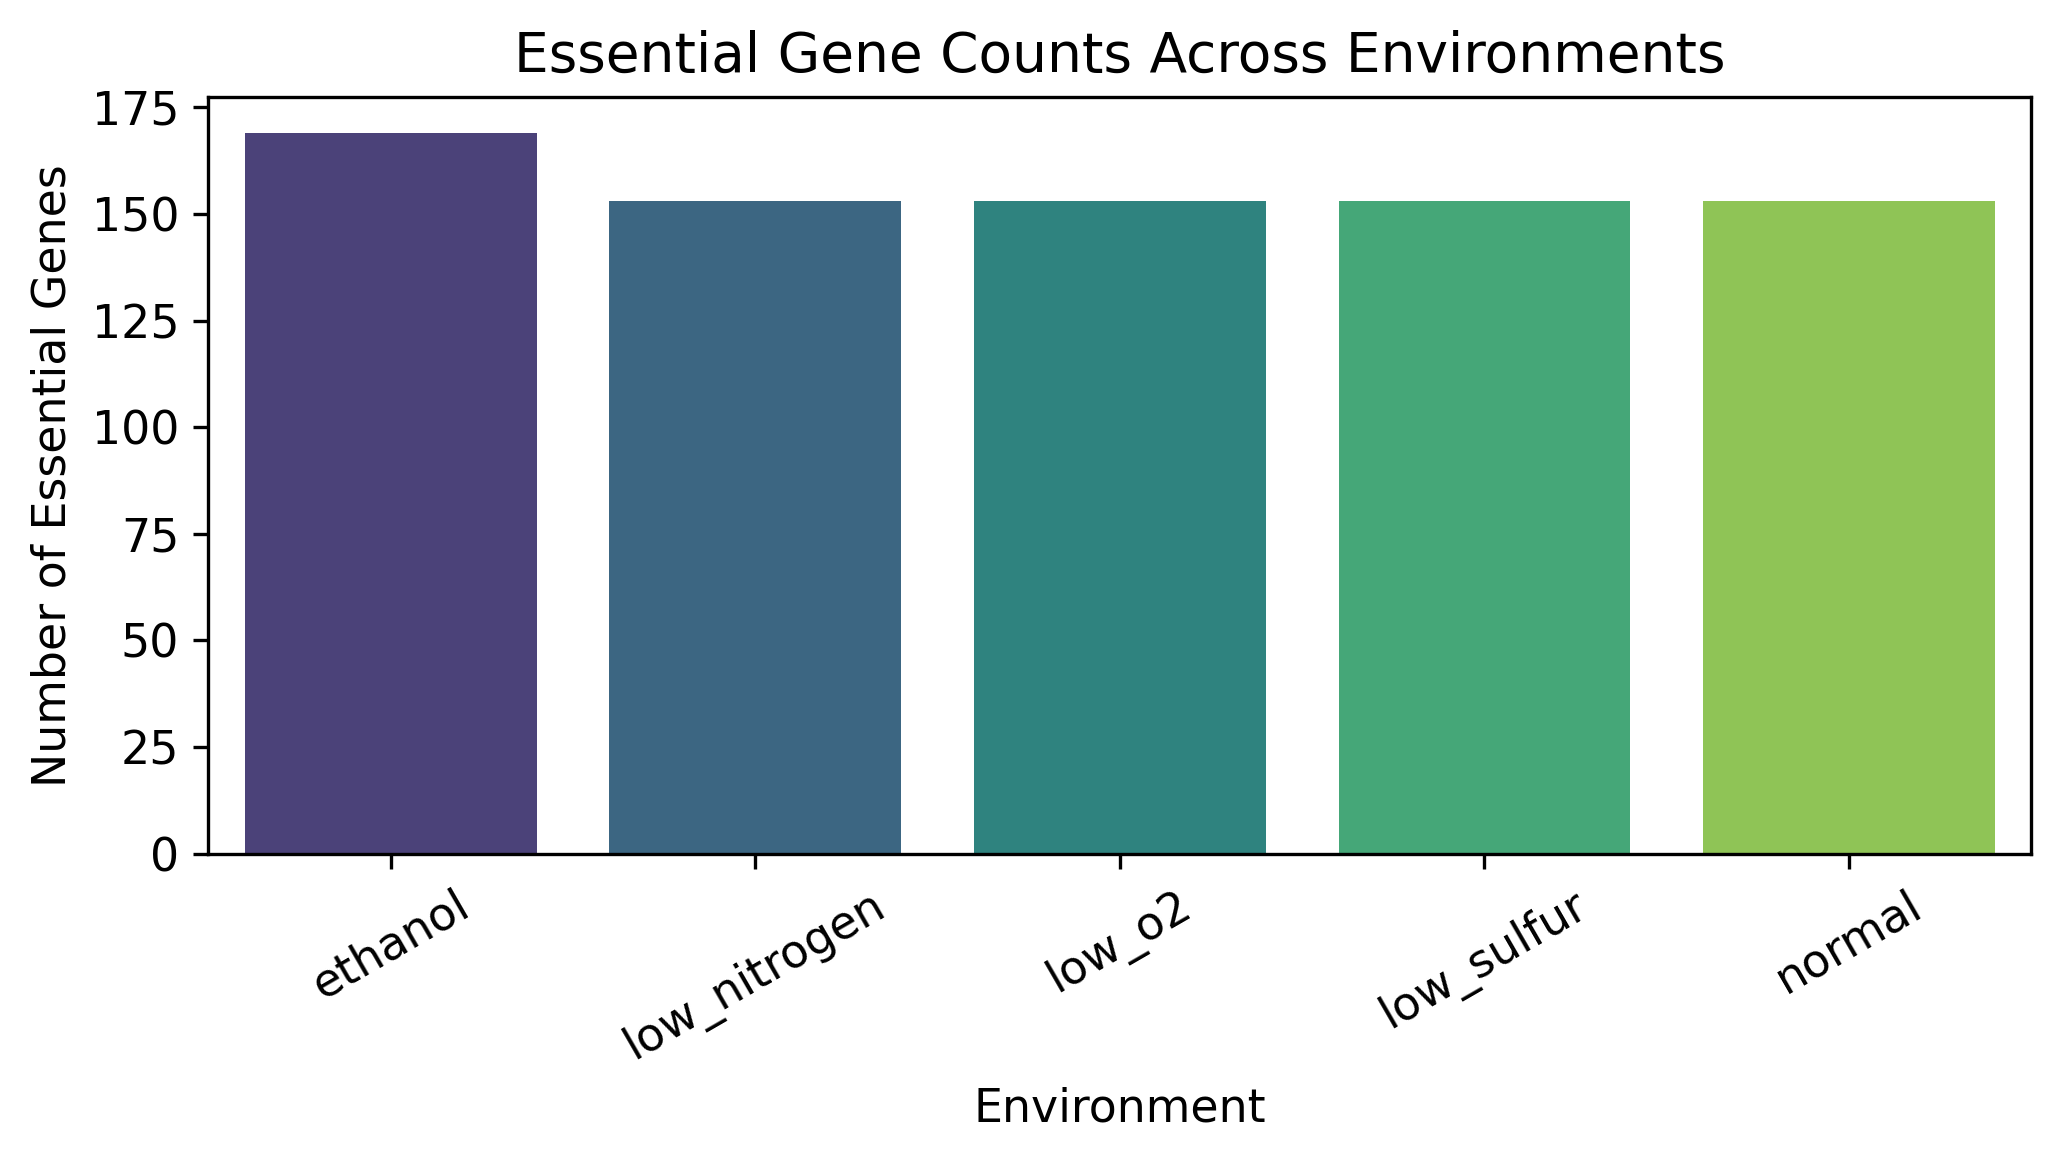

In [11]:
# Count essential genes per environment
counts = multi_env.groupby("environment")["essential"].sum().sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")
plt.title("Essential Gene Counts Across Environments")
plt.xlabel("Environment")
plt.ylabel("Number of Essential Genes")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [12]:
import os

fig_dir = "cryptococcus_project/scaffold/cryptococcus_dl/analysis/figures"
os.makedirs(fig_dir, exist_ok=True)
print("Saving figures to:", fig_dir)


Saving figures to: cryptococcus_project/scaffold/cryptococcus_dl/analysis/figures


/local_scratch/slurm.7496966/ipykernel_966542/4233969241.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


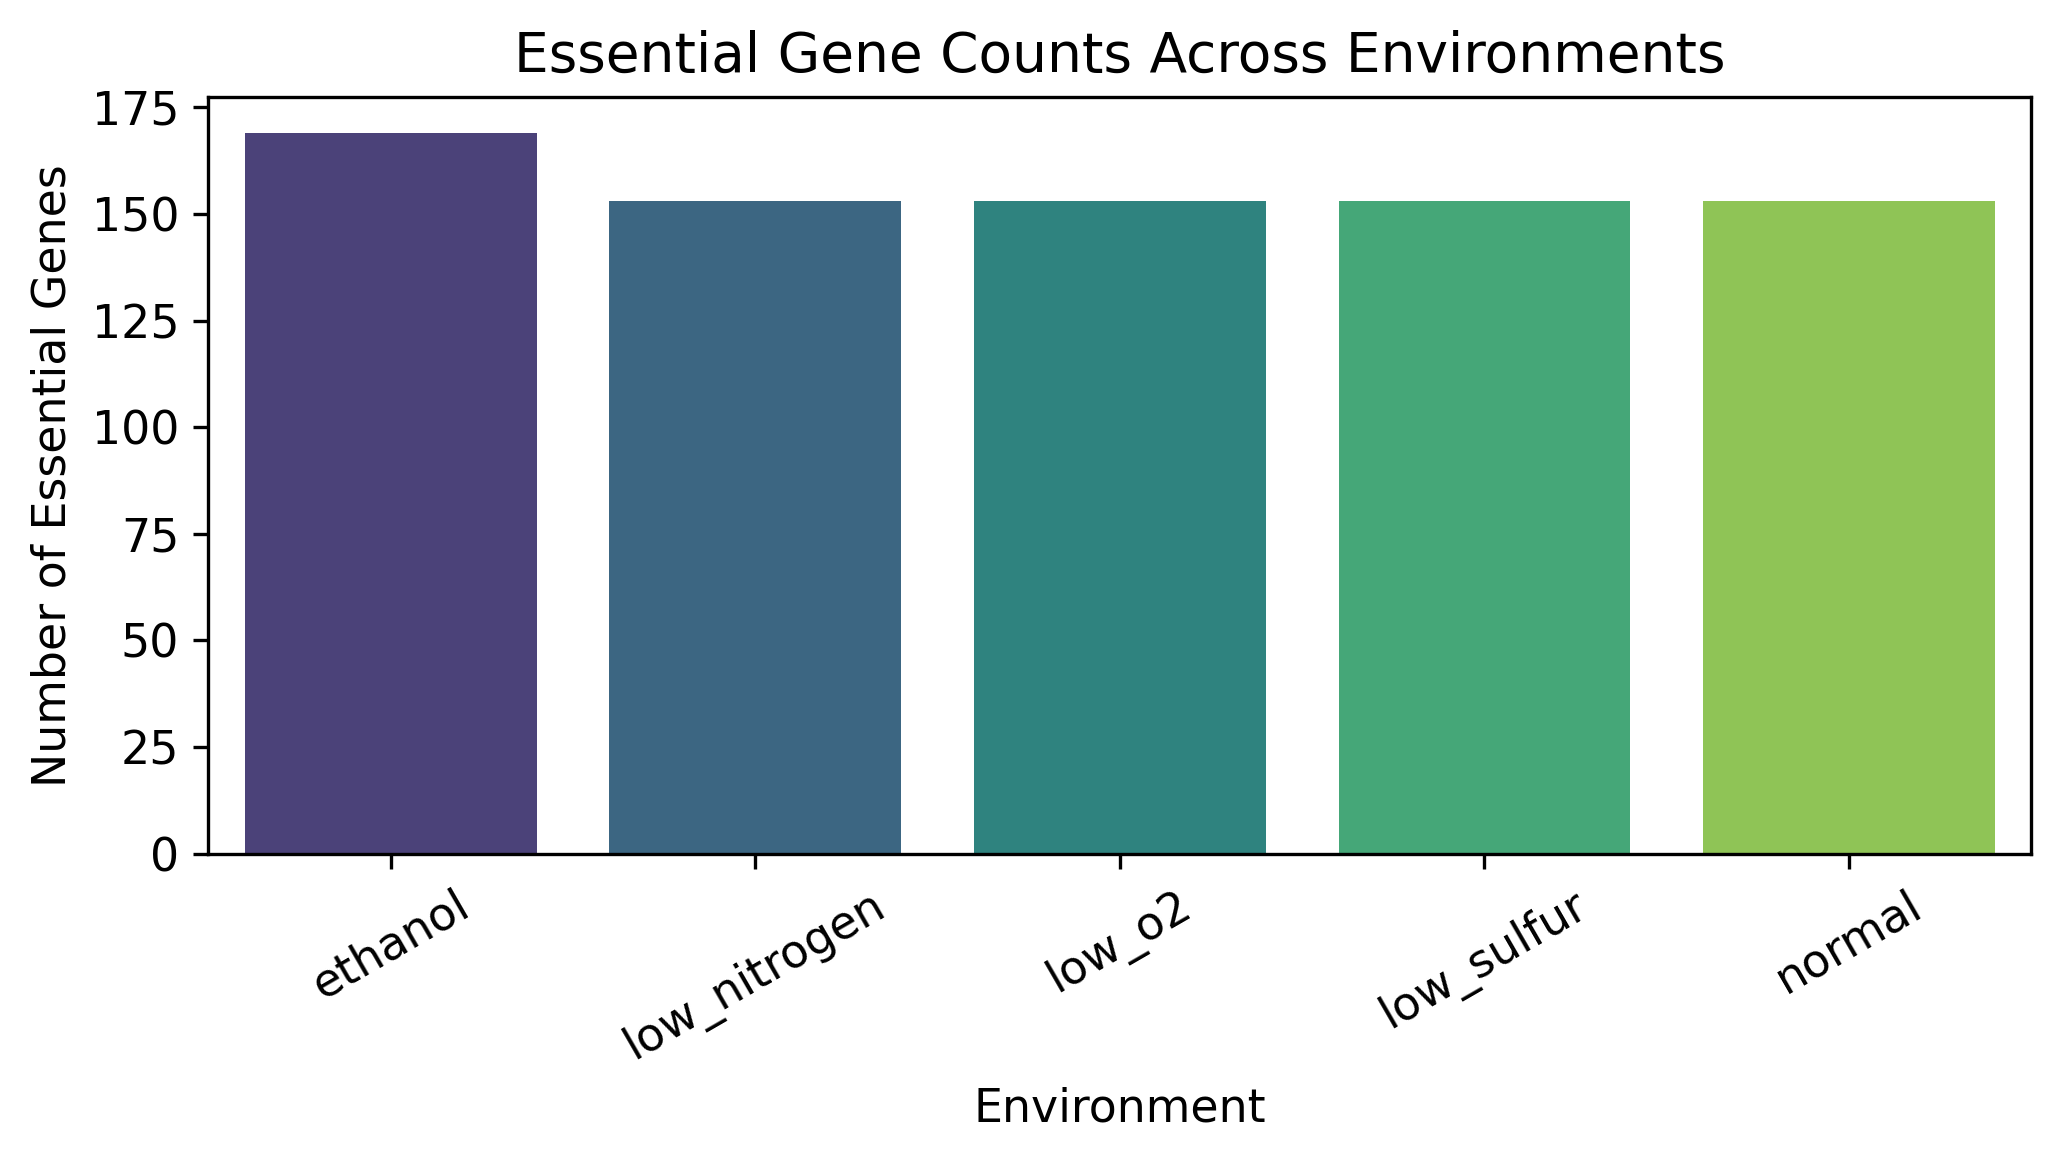

Saved: cryptococcus_project/scaffold/cryptococcus_dl/analysis/figures/figure2A_essential_counts.png


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
multi_env = pd.read_csv("cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv")

# Essential counts
counts = multi_env.groupby("environment")["essential"].sum().sort_index()

# Plot
plt.figure(figsize=(7,4))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")
plt.title("Essential Gene Counts Across Environments")
plt.xlabel("Environment")
plt.ylabel("Number of Essential Genes")
plt.xticks(rotation=30)
plt.tight_layout()

# SAVE
fig_path1 = f"{fig_dir}/figure2A_essential_counts.png"
plt.savefig(fig_path1, dpi=300, bbox_inches="tight")

plt.show()
print("Saved:", fig_path1)


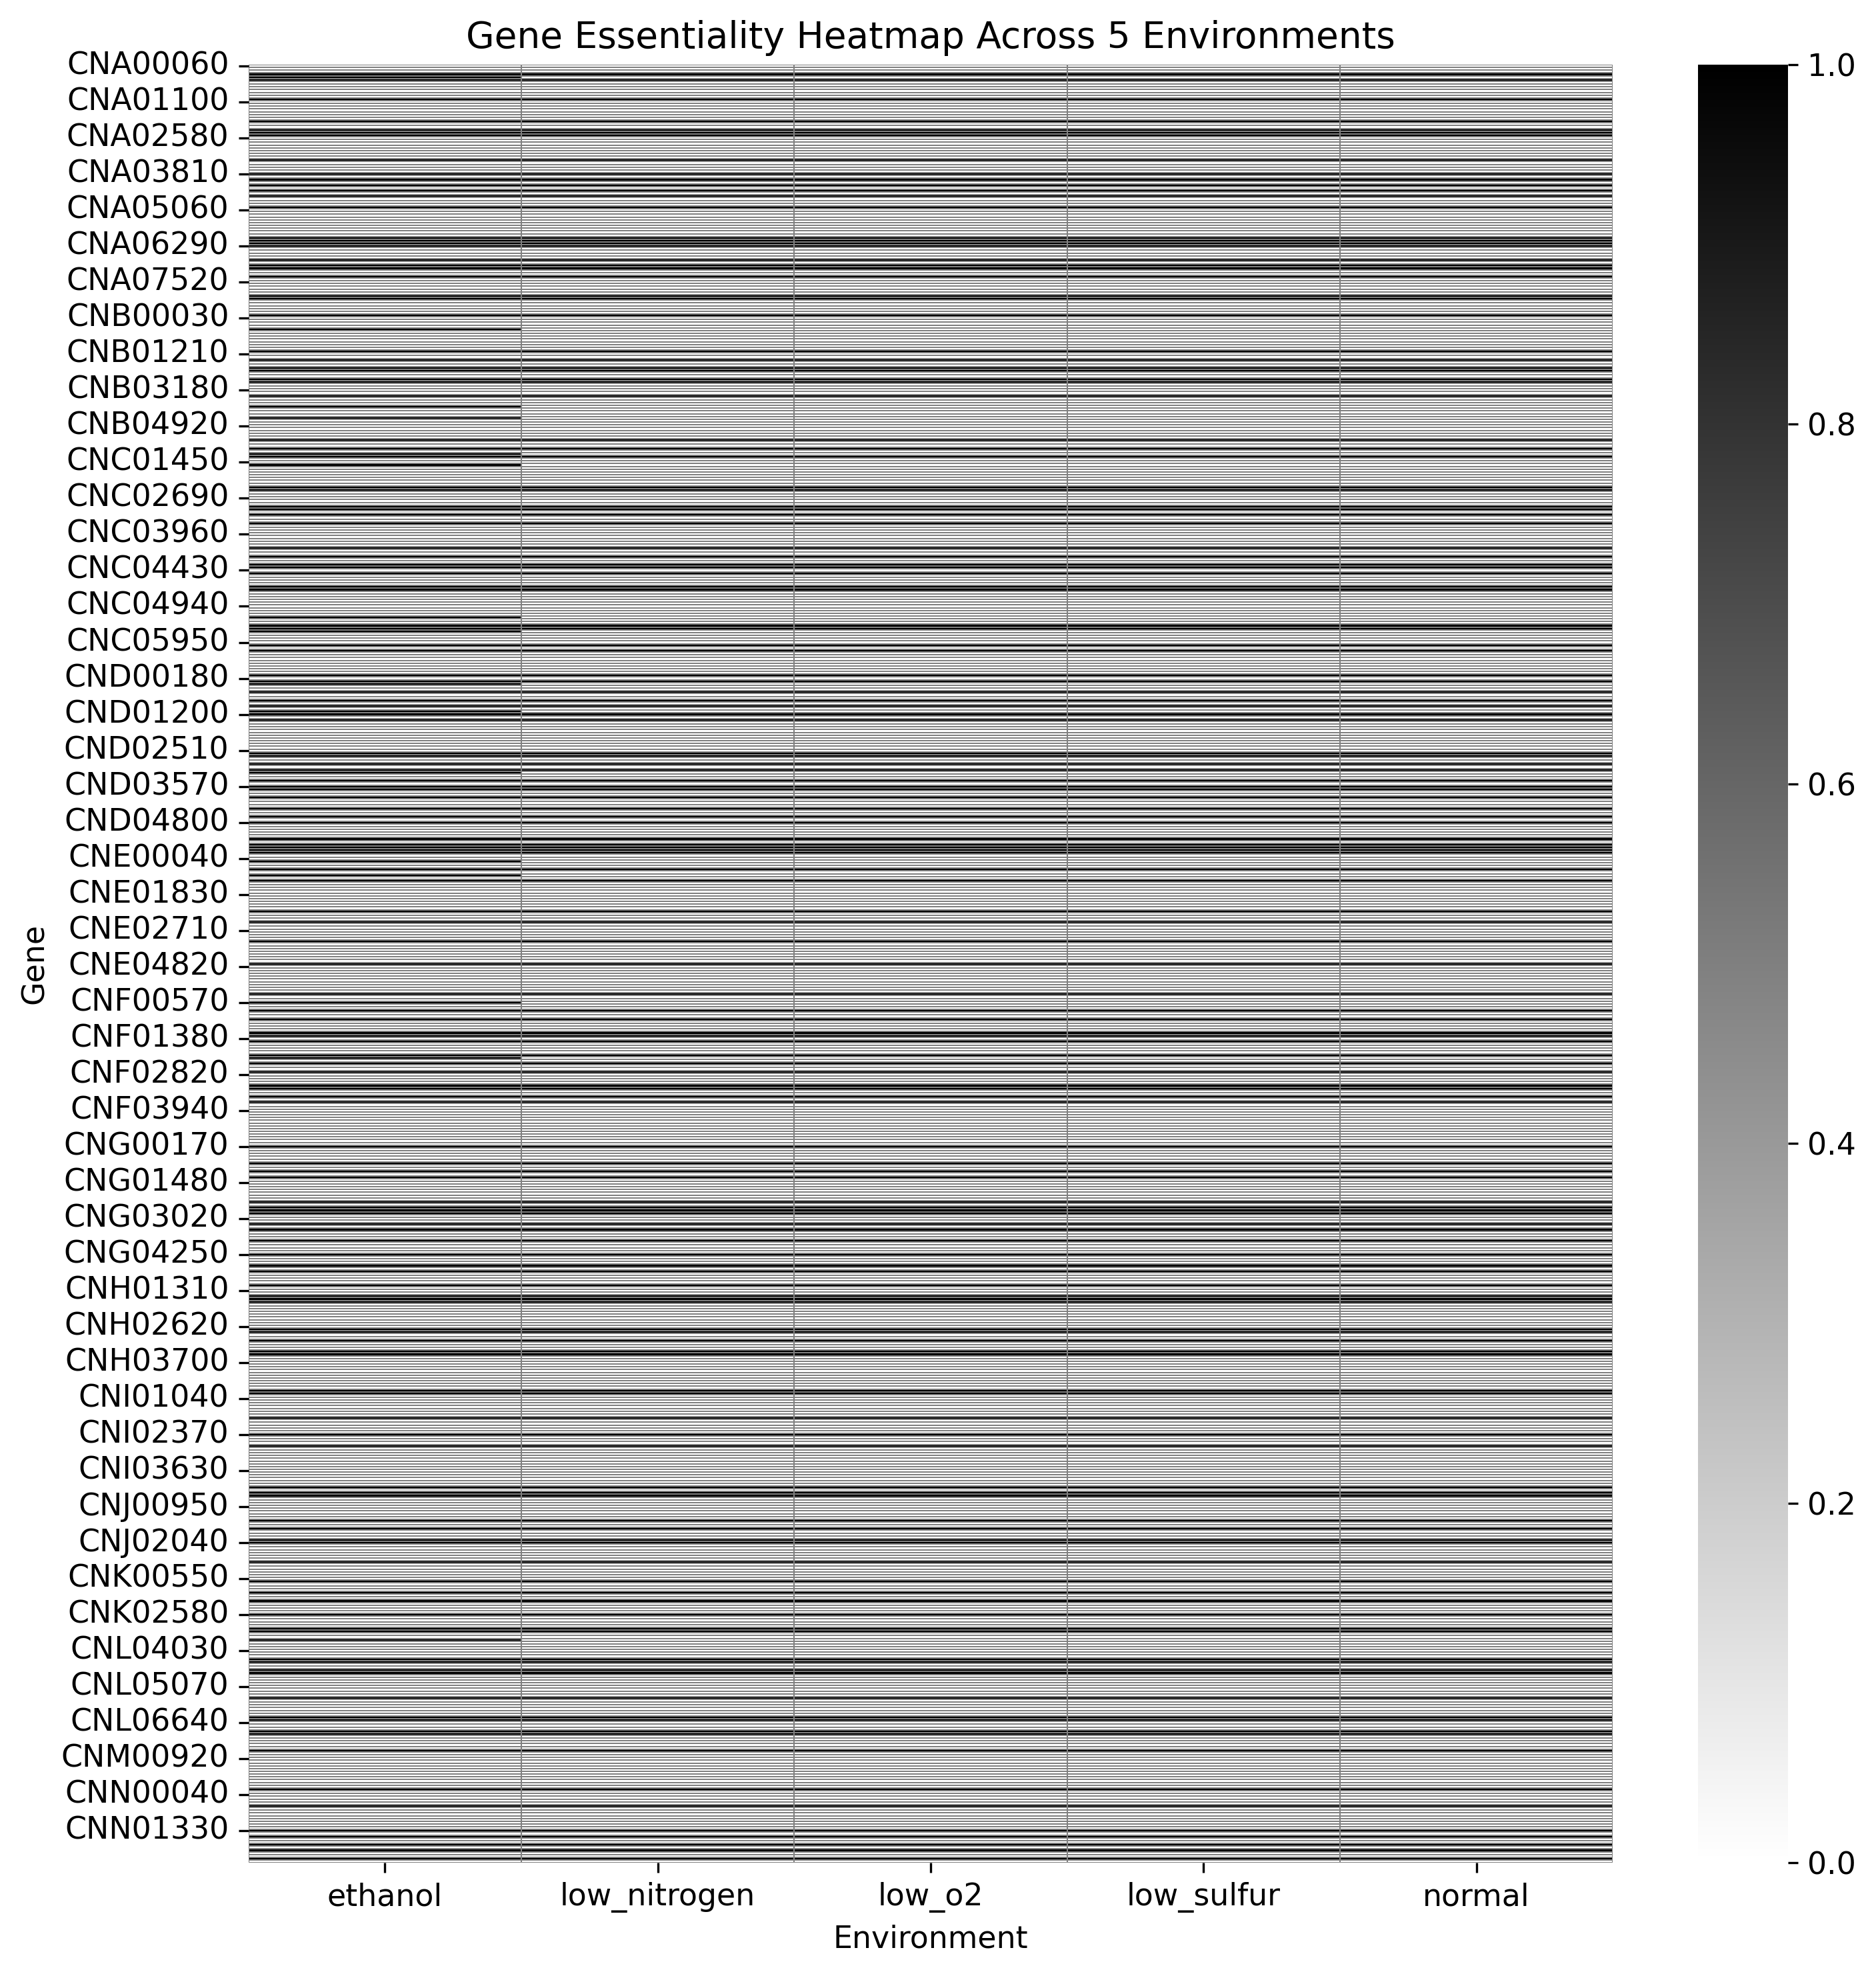

Saved: cryptococcus_project/scaffold/cryptococcus_dl/analysis/figures/figure2B_essentiality_heatmap.png


In [14]:
# Prepare pivot
pivot = multi_env.pivot(index="gene", columns="environment", values="essential").fillna(0)

plt.figure(figsize=(10,10))
sns.heatmap(
    pivot,
    cmap="binary",
    cbar=True,
    linewidths=0.1,
    linecolor="gray"
)
plt.title("Gene Essentiality Heatmap Across 5 Environments")
plt.xlabel("Environment")
plt.ylabel("Gene")
plt.tight_layout()

# SAVE
fig_path2 = f"{fig_dir}/figure2B_essentiality_heatmap.png"
plt.savefig(fig_path2, dpi=300, bbox_inches="tight")

plt.show()
print("Saved:", fig_path2)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# -------------------------------
# LOAD FILES YOU ACTUALLY HAVE
# -------------------------------

gene_path = "cryptococcus_project/scaffold/cryptococcus_dl/analysis/gene_essentiality_labels.csv"
multi_env_path = "cryptococcus_project/scaffold/cryptococcus_dl/analysis/multi_environment_essentiality.csv"
reaction_graph_path = "cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph.pkl"
metabolite_graph_path = "cryptococcus_project/scaffold/cryptococcus_dl/graphs/metabolic_graph_metabolite_adj.pkl"

genes_df = pd.read_csv(gene_path)
multi_df = pd.read_csv(multi_env_path)

with open(reaction_graph_path, "rb") as f:
    G_reaction = pickle.load(f)

with open(metabolite_graph_path, "rb") as f:
    G_metabolite = pickle.load(f)

# -------------------------------
# FIGURE 1 — WORKFLOW DIAGRAM
# -------------------------------
def fig1_pipeline():
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis("off")
    boxes = [
        ("Load iCryptococcus\nModel", (0.1, 0.5)),
        ("Run FBA\nKnockouts", (0.3, 0.5)),
        ("Simulate 5\nEnvironments", (0.5, 0.5)),
        ("Build Graphs\n(PPI/Metabolite)", (0.7, 0.5)),
        ("Analyze Essentiality", (0.9, 0.5)),
    ]
    width = 0.15
    height = 0.25
    for label, (x, y) in boxes:
        rect = FancyBboxPatch((x - width / 2, y - height / 2), width, height, boxstyle="round,pad=0.02")
        ax.add_patch(rect)
        ax.text(x, y, label, ha="center", va="center", fontsize=9)
    for i in range(len(boxes) - 1):
        x1, y1 = boxes[i][1]
        x2, y2 = boxes[i+1][1]
        arrow = FancyArrowPatch((x1 + width/2, y1), (x2 - width/2, y2), arrowstyle="->")
        ax.add_patch(arrow)
    plt.savefig("fig1_pipeline.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 2 — WT GROWTH
# -------------------------------
def fig2_wt_growth():
    wt_growth = genes_df["growth"].iloc[0]
    fig, ax = plt.subplots()
    ax.bar(["Wild-type"], [wt_growth])
    ax.set_ylabel("Biomass Flux")
    plt.savefig("fig2_wt_growth.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 3 — Knockout growth histogram
# -------------------------------
def fig3_knockout_hist():
    fig, ax = plt.subplots()
    ax.hist(genes_df["growth"], bins=30)
    ax.set_xlabel("Knockout Growth Rate")
    ax.set_ylabel("Count")
    plt.savefig("fig3_knockout_hist.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 4 — Essential vs Non-essential
# -------------------------------
def fig4_essential():
    counts = genes_df["essential"].value_counts()
    fig, ax = plt.subplots()
    ax.bar(["Non-Essential", "Essential"], [counts.get(0,0), counts.get(1,0)])
    ax.set_ylabel("Gene Count")
    plt.savefig("fig4_essential_vs_nonessential.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 5 — Essential across environments
# -------------------------------
def fig5_env_counts():
    env_counts = multi_df.groupby("environment")["essential"].sum()
    fig, ax = plt.subplots()
    ax.bar(env_counts.index, env_counts.values)
    ax.set_ylabel("Essential Gene Count")
    plt.xticks(rotation=45)
    plt.savefig("fig5_env_essential_counts.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 6 — Overlap summary
# -------------------------------
def fig6_overlap():
    envs = multi_df["environment"].unique()
    essential_map = {}

    for gene in multi_df["gene"].unique():
        subset = multi_df[multi_df["gene"] == gene]
        essential_map[gene] = tuple(subset["essential"])

    always = sum(1 for g in essential_map if all(essential_map[g]))
    never = sum(1 for g in essential_map if not any(essential_map[g]))
    conditional = len(essential_map) - always - never

    fig, ax = plt.subplots()
    ax.bar(["Always", "Never", "Conditional"], [always, never, conditional])
    plt.savefig("fig6_overlap.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 7 — Reaction-sharing graph visualization
# -------------------------------
def fig7_reaction_graph():
    pos = nx.spring_layout(G_reaction, seed=42)
    deg = dict(G_reaction.degree())
    sizes = [50 + deg[n]*2 for n in G_reaction.nodes()]
    fig, ax = plt.subplots(figsize=(6,6))
    nx.draw(G_reaction, pos, node_size=sizes, edge_color="gray", alpha=0.6, ax=ax)
    ax.set_axis_off()
    plt.savefig("fig7_reaction_graph.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 8 — Metabolite graph degree histogram
# -------------------------------
def fig8_metabolite_degree():
    degrees = [d for _, d in G_metabolite.degree()]
    fig, ax = plt.subplots()
    ax.hist(degrees, bins=40)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Number of genes")
    plt.savefig("fig8_metabolite_degree_hist.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 9 — Centrality Distributions
# -------------------------------
def fig9_centrality():
    deg = dict(G_metabolite.degree())
    bet = nx.betweenness_centrality(G_metabolite)
    clo = nx.closeness_centrality(G_metabolite)

    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].hist(deg.values(), bins=40)
    axes[0].set_title("Degree")
    axes[1].hist(bet.values(), bins=40)
    axes[1].set_title("Betweenness")
    axes[2].hist(clo.values(), bins=40)
    axes[2].set_title("Closeness")
    plt.savefig("fig9_centrality_distributions.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 10 — Dataset structure heatmap (only available columns)
# -------------------------------
def fig10_dataset_structure():
    example_features = multi_df[["growth", "essential"]].head(50)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(example_features.T, aspect="auto", cmap="viridis")
    ax.set_yticks([0,1])
    ax.set_yticklabels(["growth","essential"])
    ax.set_xticks([])
    plt.savefig("fig10_dataset_structure.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 11 — Label Distribution
# -------------------------------
def fig11_label_dist():
    counts = multi_df["essential"].value_counts()
    fig, ax = plt.subplots()
    ax.bar(["Non-essential","Essential"], [counts.get(0,0), counts.get(1,0)])
    plt.savefig("fig11_label_distribution.png", dpi=300)
    plt.close()

# -------------------------------
# FIGURE 18 — Final summary figure
# -------------------------------
def fig18_summary():
    envs = multi_df["environment"].unique()
    essential_map = {}

    for gene in multi_df["gene"].unique():
        subset = multi_df[multi_df["gene"] == gene]
        essential_map[gene] = tuple(subset["essential"])

    always = sum(1 for g in essential_map if all(essential_map[g]))
    never = sum(1 for g in essential_map if not any(essential_map[g]))
    conditional = len(essential_map) - always - never

    fig, ax = plt.subplots()
    ax.axis("off")
    txt = f"""
Essentiality Summary
---------------------

Always essential: {always}
Never essential: {never}
Condition-specific: {conditional}
"""
    ax.text(0.05, 0.8, txt, fontsize=12, va="top")
    plt.savefig("fig18_summary.png", dpi=300)
    plt.close()

# -------------------------------
# RUN EVERYTHING
# -------------------------------
fig1_pipeline()
fig2_wt_growth()
fig3_knockout_hist()
fig4_essential()
fig5_env_counts()
fig6_overlap()
fig7_reaction_graph()
fig8_metabolite_degree()
fig9_centrality()
fig10_dataset_structure()
fig11_label_dist()
fig18_summary()
